# Installs

In [1]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 121 kB/s 


# Imports

In [3]:
import kaleido
import pandas as pd
import numpy as np
import networkx as nx
# from afinn import Afinn
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
import plotly.express as px
from typing import Union, List, Dict, Tuple
from tqdm.notebook import tqdm
from functools import lru_cache
import os
import warnings

# Read Data

## Mount Drive

In [ ]:
from google.colab import drive, output
drive.mount('/content/drive')
BEEP = lambda: output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

Mounted at /content/drive


## Set Directories' Paths

In [4]:
DATA_DIR_PATH = r"/content/drive/MyDrive/NLP_And_Social_Dynamics/Data"  # Data directory, as set in our drive
IRA_DIR_PATH = os.path.join(DATA_DIR_PATH, 'IRA_tweets', 'Raw')  # IRA data directory
PREPROCESSED_DIR_PATH = os.path.join(DATA_DIR_PATH, 'preprocessed_data')  # Preprocessed data

## Load and concat raw data

In [ ]:
def get_ira_unite_df(ira_dir_path: str, prog_bar: bool=True) -> pd.DataFrame:
    """
    reads all the file paths and return a unite dataframe
    :param ira_dir_path: (str) the path to the directory
    :param prog_bar: (bool) rather showing progress bar for reading the files (default=True)
    :return: (pd.DataFrame) the unite dataframe
    """
    fps = [os.path.join(ira_dir_path, fn) for fn in os.listdir(ira_dir_path)]
    fps = sorted(fps, key=lambda x: int(x.strip('.csv').split('_')[-1]))
    dfs = [pd.read_csv(fp) for fp in tqdm(fps, disable=not prog_bar)]
    return pd.concat(dfs)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (11,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(2530724, 21)

### Create and Write unite IRA dataset

In [ ]:
# ira_df = get_ira_unite_df(IRA_DIR_PATH)
# ira_df.to_csv(r"/content/drive/MyDrive/NLP_And_Social_Dynamics/Data/preprocessed_data/ira_tweets.csv")

### Read unite IRA dataset

In [ ]:
ira_df = pd.read_csv(r"/content/drive/MyDrive/NLP_And_Social_Dynamics/Data/preprocessed_data/ira_tweets.csv", usecols=lambda col: 'unname' not in col.lower())
ira_df.shape

### Exploration of full ira tweets dataset

In [ ]:
ira_df['account_type'].unique().shape

(20,)

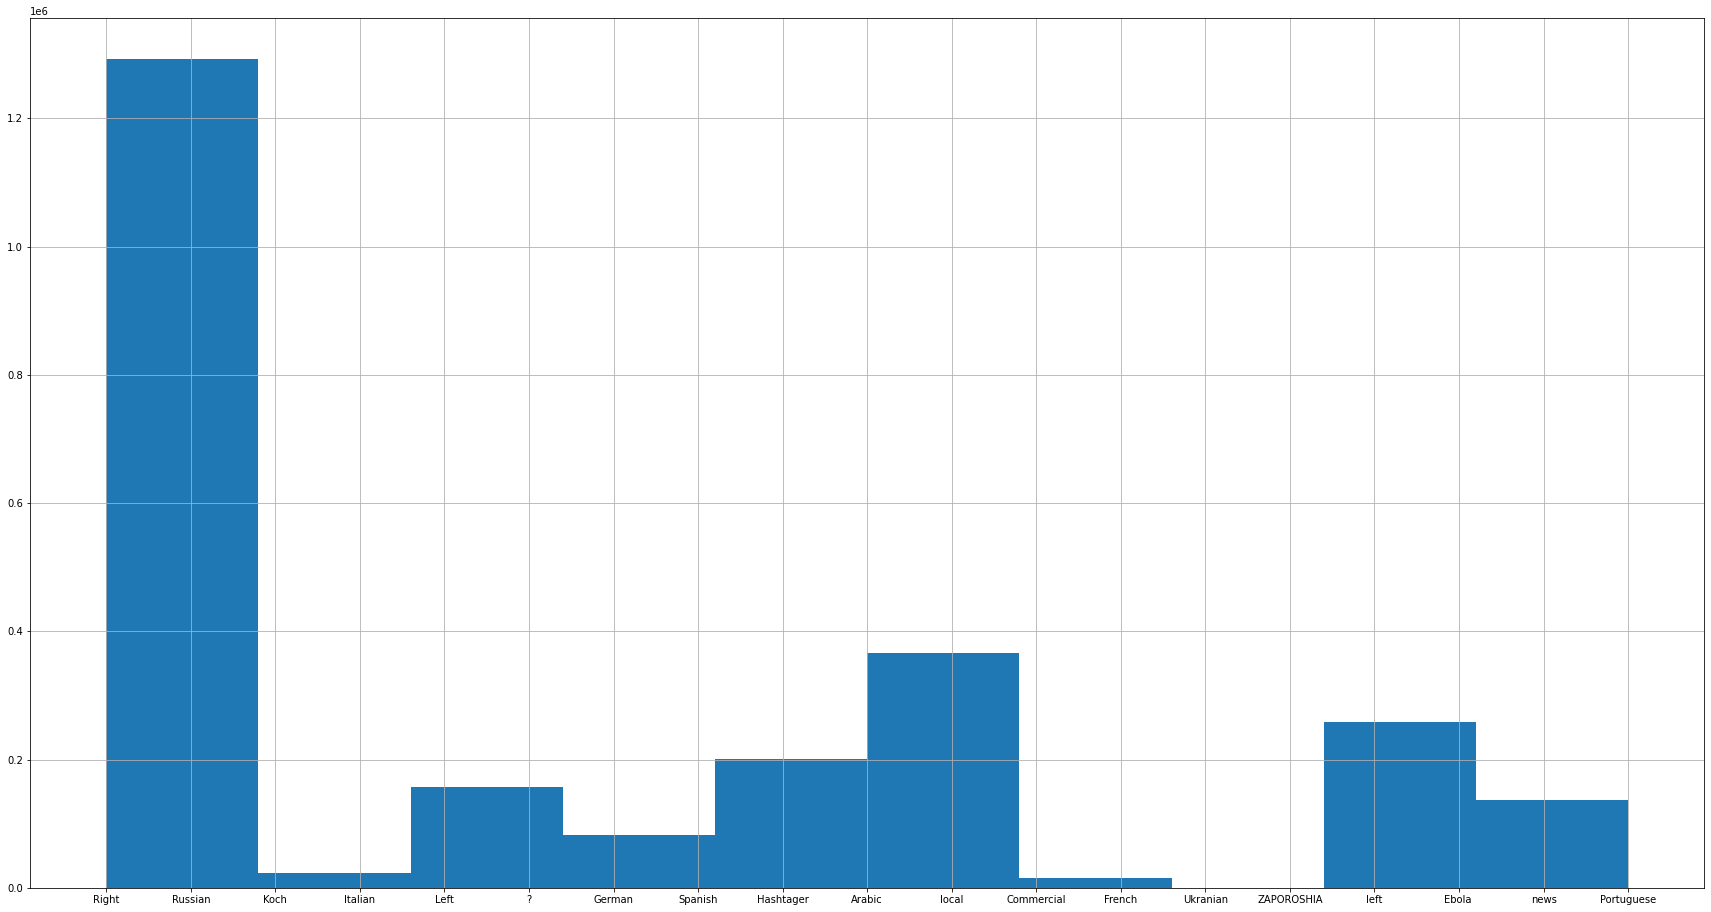

In [ ]:
plt.figure(figsize=(30, 16))
ira_df['account_type'].hist()

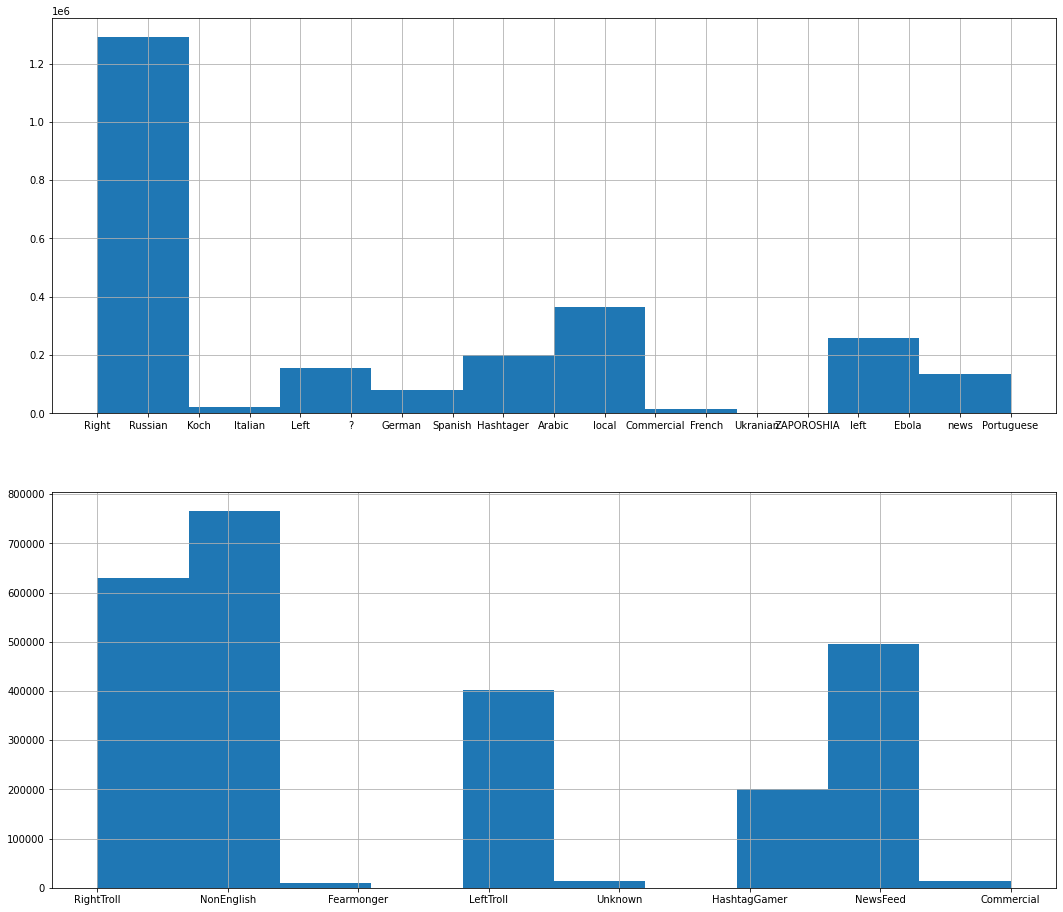

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(18, 16))
ira_df['account_type'].hist(ax=axes[0])
ira_df['account_category'].hist(ax=axes[1])
plt.show()

# Find Users' Hash and Define UIDs

In [ ]:
misinfo_df = pd.read_csv(os.path.join(DATA_DIR_PATH, 'misinfo_trolloutput.csv'))  # enter path to misinfo dataset
misinfo_df.rename(columns={'tweetid': 'tweet_id'}, inplace=True)
misinfo_df.head()

,tweet_id,userid_hash,user_screen_name_hash,final_profile_description,followers,tweet_time,retweet_userid,in_reply_to_userid,account_type,rt_atype,reply_atype,is_ext_retweet,is_ext_reply,harvested_date
0,551323974035316736,446814d058a75d9f90076c02b125e5adfc64ddd544cf07...,446814d058a75d9f90076c02b125e5adfc64ddd544cf07...,Remember no one can make you feel inferior wit...,NaN,2015-01-03 10:27,NaN,NaN,HashtagGamer,NaN,NaN,False,False,NaN
1,551323948772646913,fe5db840484645a82182175e7e933fb2adcaa23380444a...,fe5db840484645a82182175e7e933fb2adcaa23380444a...,barely legal,NaN,2015-01-03 10:27,NaN,NaN,HashtagGamer,NaN,NaN,False,False,NaN
2,551324083489492993,fe5db840484645a82182175e7e933fb2adcaa23380444a...,fe5db840484645a82182175e7e933fb2adcaa23380444a...,barely legal,NaN,2015-01-03 10:27,NaN,NaN,HashtagGamer,NaN,NaN,False,False,NaN
3,551323907383238657,819a70950d1055f5a541a7bbf42b9be7bcf6a06dd77303...,819a70950d1055f5a541a7bbf42b9be7bcf6a06dd77303...,Conservative/Libertarian #RedNationRising #tco...,15.0,2015-01-03 10:27,NaN,NaN,RightTroll,NaN,NaN,False,False,1/3/2015 10:27
4,551324070793330688,cab81bd7dd0e2c2c53c52cfbc0d5146b6e2f190a6e7e59...,cab81bd7dd0e2c2c53c52cfbc0d5146b6e2f190a6e7e59...,We must believe that we are gifted for somethi...,NaN,2015-01-03 10:27,NaN,NaN,HashtagGamer,NaN,NaN,False,False,NaN


## Explore misinfo dataset

In [ ]:
np.union1d(misinfo_df['rt_atype'].unique()[1:], misinfo_df['reply_atype'].unique()[1:])

array(['Fearmonger', 'HashtagGamer', 'LeftTroll', 'Newsfeed',
       'NonEnglish', 'RightTroll', 'Unknown'], dtype=object)

In [ ]:
misinfo_df['account_type'].unique()

array(['HashtagGamer', 'RightTroll', 'LeftTroll'], dtype=object)

In [ ]:
misinfo_df['userid_hash'].unique().shape

(784,)

## 'tweet_id'-based join between misinfo and IRA datasets on 

In [ ]:
joined_df = pd.merge(misinfo_df, ira_df, on='tweet_id', suffixes=('_mis', '_ira'))
joined_df.head()

,tweet_id,userid_hash,user_screen_name_hash,final_profile_description,followers_mis,tweet_time,retweet_userid,in_reply_to_userid,account_type_mis,rt_atype,...,post_type,account_type_ira,retweet,account_category,new_june_2018,alt_external_id,article_url,tco1_step1,tco2_step1,tco3_step1
0,552475834658086912,71db45e4783602194ced17d50c4070036dfc754e9557fe...,71db45e4783602194ced17d50c4070036dfc754e9557fe...,"Very outspoken, but don't take it for anger. x...",64.0,2015-01-06 14:44,NaN,NaN,LeftTroll,NaN,...,NaN,Left,0,LeftTroll,0,1.652139e+09,http://twitter.com/acejinev/statuses/552475834...,NaN,NaN,NaN
1,552475784288690176,71db45e4783602194ced17d50c4070036dfc754e9557fe...,71db45e4783602194ced17d50c4070036dfc754e9557fe...,"Very outspoken, but don't take it for anger. x...",64.0,2015-01-06 14:44,NaN,NaN,LeftTroll,NaN,...,NaN,Left,0,LeftTroll,0,1.652139e+09,http://twitter.com/acejinev/statuses/552475784...,NaN,NaN,NaN
2,552475721374121984,ef983249ef6ed5de427c4dc19ad6d966c6cf572c2505e4...,ef983249ef6ed5de427c4dc19ad6d966c6cf572c2505e4...,Fun-loving conservative sharing the truth that...,60.0,2015-01-06 14:44,NaN,NaN,RightTroll,NaN,...,NaN,Right,0,RightTroll,0,1.629828e+09,http://twitter.com/cassishere/statuses/5524757...,NaN,NaN,NaN
3,552475758896353280,ef983249ef6ed5de427c4dc19ad6d966c6cf572c2505e4...,ef983249ef6ed5de427c4dc19ad6d966c6cf572c2505e4...,Fun-loving conservative sharing the truth that...,60.0,2015-01-06 14:44,NaN,NaN,RightTroll,NaN,...,NaN,Right,0,RightTroll,0,1.629828e+09,http://twitter.com/cassishere/statuses/5524757...,NaN,NaN,NaN
4,552475998676348928,71db45e4783602194ced17d50c4070036dfc754e9557fe...,71db45e4783602194ced17d50c4070036dfc754e9557fe...,"Very outspoken, but don't take it for anger. x...",64.0,2015-01-06 14:45,NaN,NaN,LeftTroll,NaN,...,NaN,Left,0,LeftTroll,0,1.652139e+09,http://twitter.com/acejinev/statuses/552475998...,NaN,NaN,NaN


### Explore joined dataset

In [ ]:
joined_df.columns

Index(['tweet_id', 'userid_hash', 'user_screen_name_hash',
       'final_profile_description', 'followers_mis', 'tweet_time',
       'retweet_userid', 'in_reply_to_userid', 'account_type_mis', 'rt_atype',
       'reply_atype', 'is_ext_retweet', 'is_ext_reply', 'harvested_date_mis',
       'external_author_id', 'author', 'content', 'region', 'language',
       'publish_date', 'harvested_date_ira', 'following', 'followers_ira',
       'updates', 'post_type', 'account_type_ira', 'retweet',
       'account_category', 'new_june_2018', 'alt_external_id', 'article_url',
       'tco1_step1', 'tco2_step1', 'tco3_step1'],
      dtype='object')

In [ ]:
joined_df['target_id'] = joined_df[['retweet_userid', 'in_reply_to_userid']].apply(lambda row: row['retweet_userid'] if row['retweet_userid'] == row['retweet_userid'] else row['in_reply_to_userid'] if row['in_reply_to_userid'] == row['in_reply_to_userid'] else 'not_inter', axis=1)
joined_df['target_type'] = joined_df[['retweet_userid', 'in_reply_to_userid', 'rt_atype', 'reply_atype']].apply(lambda row: row['rt_atype'] if row['retweet_userid'] == row['retweet_userid'] else row['reply_atype'] if row['in_reply_to_userid'] == row['in_reply_to_userid'] else 'not_inter', axis=1)
_cols = ['userid_hash', 'external_author_id', 'final_profile_description', 'followers_mis', 'account_type_mis', 'following', 'followers_ira', 'account_type_ira', 'account_category', 'target_type', 'target_id']
joined_df[_cols].head()

,userid_hash,external_author_id,final_profile_description,followers_mis,account_type_mis,following,followers_ira,account_type_ira,account_category,target_type,target_id
0,71db45e4783602194ced17d50c4070036dfc754e9557fe...,1.652139e+09,"Very outspoken, but don't take it for anger. x...",64.0,LeftTroll,89,64,Left,LeftTroll,not_inter,not_inter
1,71db45e4783602194ced17d50c4070036dfc754e9557fe...,1.652139e+09,"Very outspoken, but don't take it for anger. x...",64.0,LeftTroll,89,64,Left,LeftTroll,not_inter,not_inter
2,ef983249ef6ed5de427c4dc19ad6d966c6cf572c2505e4...,1.629828e+09,Fun-loving conservative sharing the truth that...,60.0,RightTroll,67,60,Right,RightTroll,not_inter,not_inter
3,ef983249ef6ed5de427c4dc19ad6d966c6cf572c2505e4...,1.629828e+09,Fun-loving conservative sharing the truth that...,60.0,RightTroll,67,60,Right,RightTroll,not_inter,not_inter
4,71db45e4783602194ced17d50c4070036dfc754e9557fe...,1.652139e+09,"Very outspoken, but don't take it for anger. x...",64.0,LeftTroll,89,64,Left,LeftTroll,not_inter,not_inter


In [ ]:
joined_df['userid_hash'].unique().shape

(210,)

In [ ]:
joined_df['target_id'].unique().shape

(43186,)

In [ ]:
np.union1d(joined_df['userid_hash'].unique(), joined_df['target_id'].unique()).shape

(43296,)

In [ ]:
joined_df['target_id'].value_counts()

not_inter             53897
329323059              1831
16973333               1778
312149882              1519
2882037326             1115
                      ...  
733609772847529984        1
3388490113                1
27951956                  1
194369195                 1
960304283337052160        1
Name: target_id, Length: 43186, dtype: int64

In [ ]:
joined_df['target_type'].value_counts()

not_inter       53897
Newsfeed        10011
HashtagGamer     5254
LeftTroll        2528
RightTroll       1139
Fearmonger         45
Unknown             4
Name: target_type, dtype: int64

### Write joined dataset

In [ ]:
# joined_df.to_csv(r"/content/drive/MyDrive/NLP_And_Social_Dynamics/Data/preprocessed_data/joined_users_dataset.csv", index=False)

### Read joined dataset

In [ ]:
joined_df = pd.read_csv(r"/content/drive/MyDrive/NLP_And_Social_Dynamics/Data/preprocessed_data/joined_users_dataset.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,7,9,33) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Interactions Dataset

In [ ]:
inters_df = joined_df[joined_df['target_id'] != 'not_inter']
inters_df['target_type'].fillna('allegedly_legit', inplace=True)
np.union1d(inters_df['userid_hash'].unique(), inters_df['target_id'].unique()).shape

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


(43269,)

### Explore interactions dataset

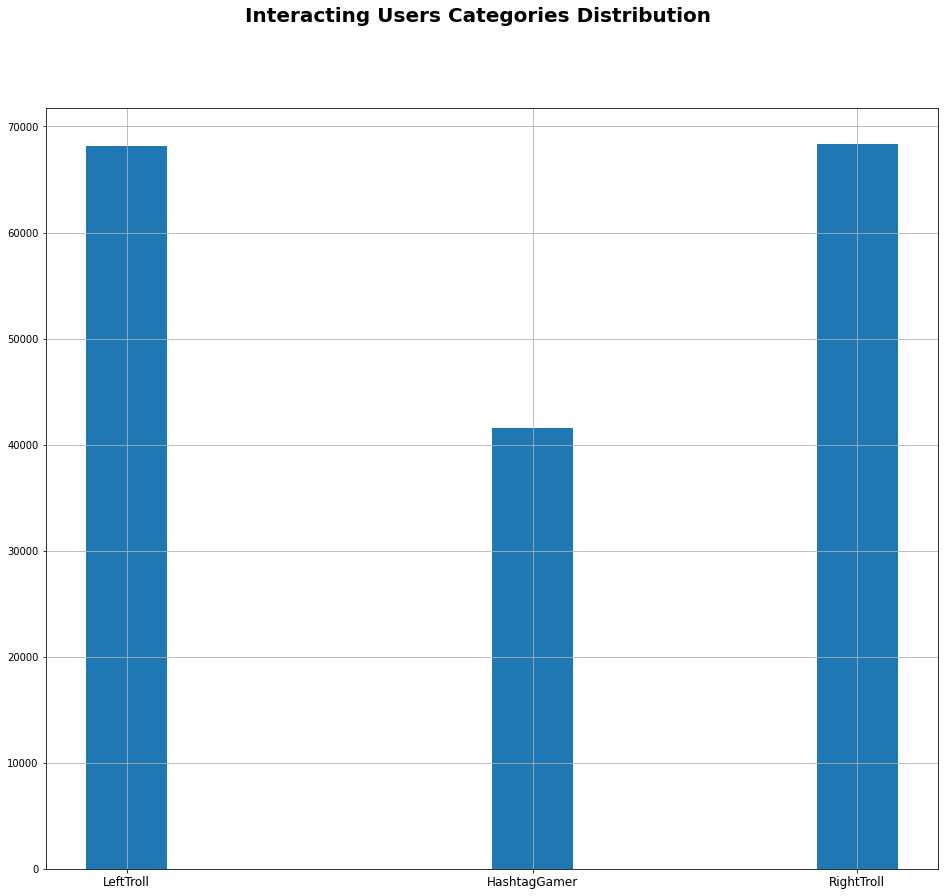

In [ ]:
fig = plt.figure(figsize=(16, 14))
fig.suptitle('Interacting Users Categories Distribution', fontsize=20, weight='bold')
_col = 'account_type_mis'
_ax = inters_df[_col].hist(xlabelsize=12)
# for tk in _ax.get_xticklabels():
#     tk.set_fontsize(12)
_ax.set_xticks(np.array(_ax.get_xticks()) + [.1, .1, -.1])
plt.show()

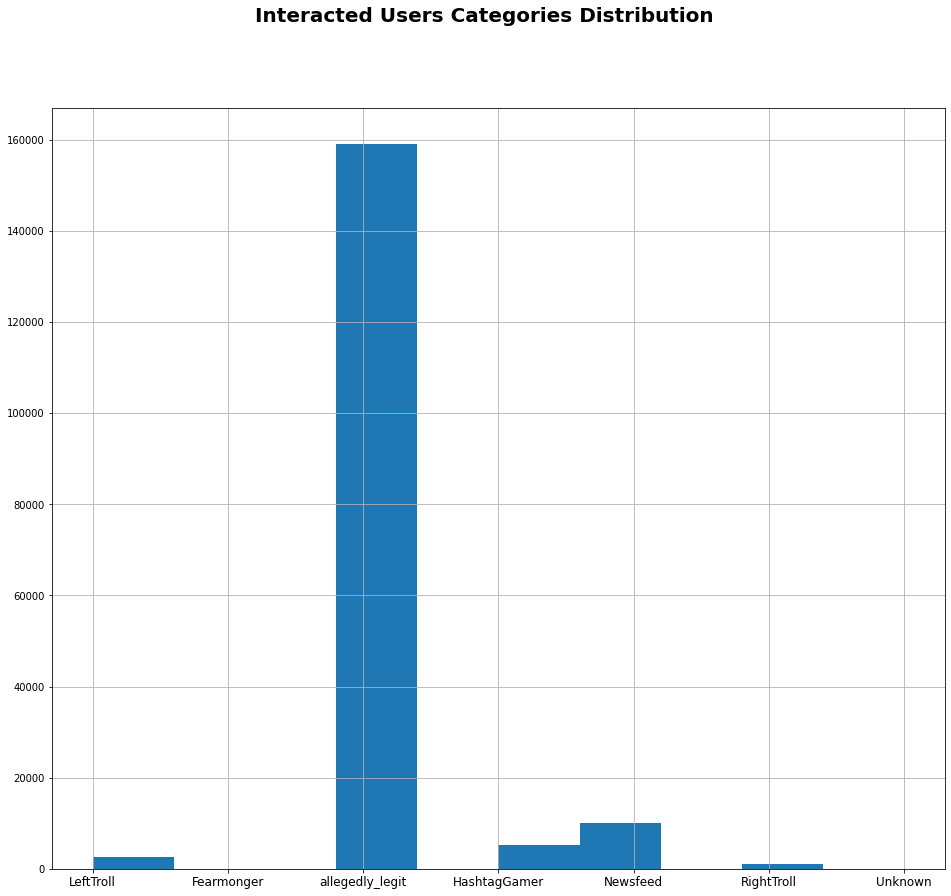

In [ ]:
fig = plt.figure(figsize=(16, 14))
fig.suptitle('Interacted Users Categories Distribution', fontsize=20, weight='bold')
_col = 'target_type'
_ax = inters_df[_col].hist(xlabelsize=12)
# for tk in _ax.get_xticklabels():
#     tk.set_fontsize(12)
# _ax_ticks = np.array(_ax.get_xticks())
# _ax_ticks = _ax_ticks - np.array([.1, .1, .1, .1, .1, .1, .1])
# _ax_ticks[-1] -= .2
# _ax.set_xticks(_ax_ticks)
plt.show()

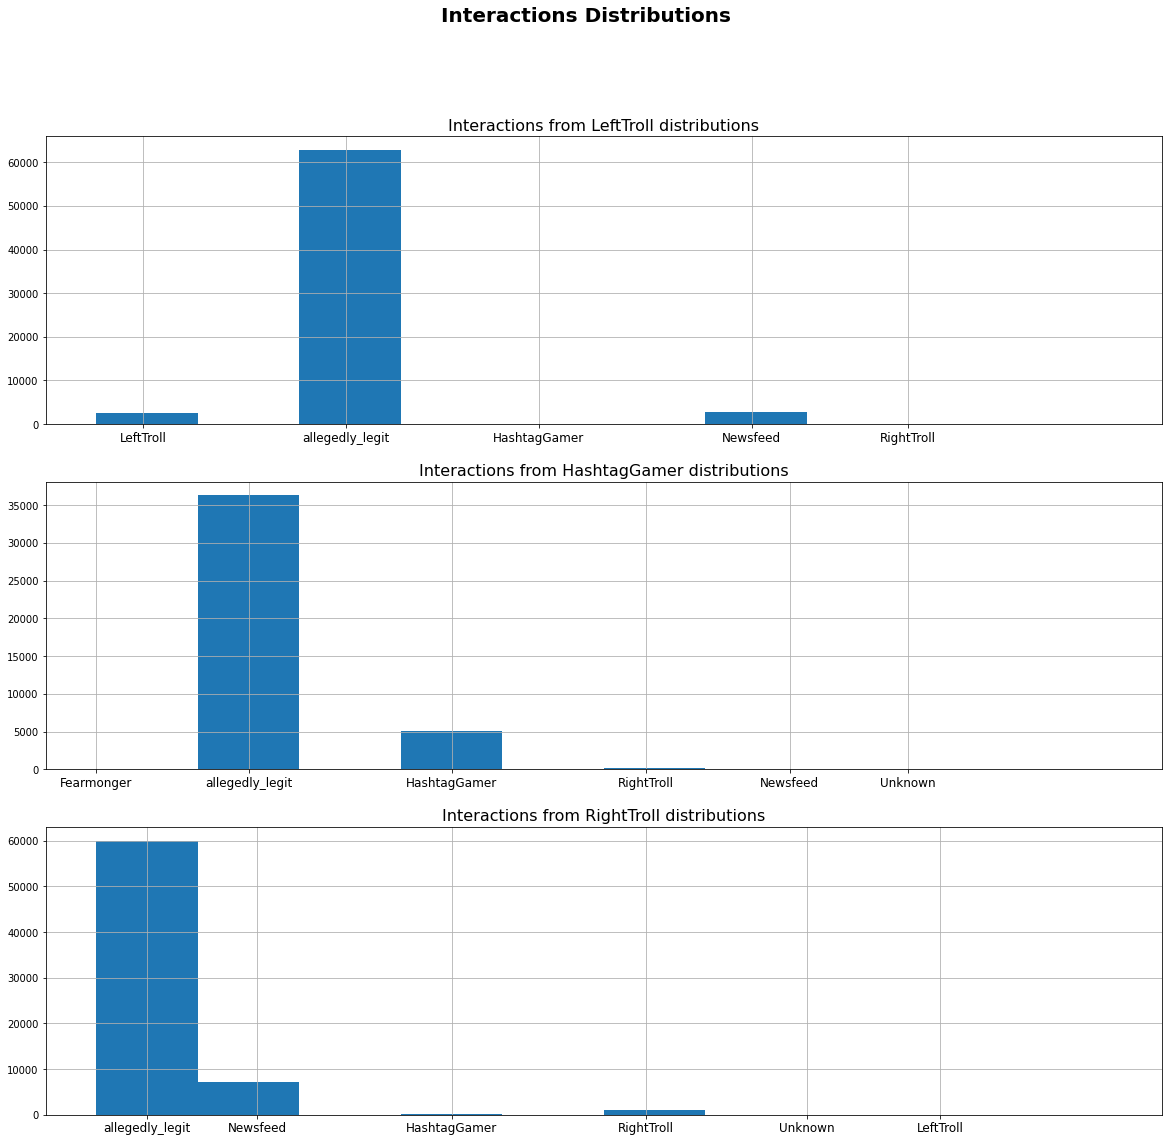

In [ ]:
fig, axes = plt.subplots(inters_df['account_type_mis'].unique().shape[0], 1, figsize=(20, 18))
fig.suptitle('Interactions Distributions', fontsize=20, weight='bold')
x_ticks = [np.arange(5) + np.array([.23, .23, .18, .23, 0.]), 
           np.arange(6) + np.array([.0, -.1, .1, .25, .1, -.2]), 
           np.arange(6) + np.array([.3, -.05, .1, .25, .2, -.01])]
for _ax, atype, xticks in zip(axes, inters_df['account_type_mis'].unique(), x_ticks):
    atype_df = inters_df[inters_df['account_type_mis'] == atype]
    _ax = atype_df['target_type'].hist(ax=_ax, xlabelsize=12)
    _ax.set_title(f"Interactions from {atype} distributions", fontdict={'fontsize': 16})
    _ax.set_xticks(xticks)

plt.show()

In [ ]:
part_cont_emb = pd.read_csv(r"/content/drive/MyDrive/NLP_And_Social_Dynamics/Data/preprocessed_data/part_uid_inter_ira.csv_content_embeddings.csv", usecols=drop_columns_func)
part_cont_emb.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,...,content_embedding_290,content_embedding_291,content_embedding_292,content_embedding_293,content_embedding_294,content_embedding_295,content_embedding_296,content_embedding_297,content_embedding_298,content_embedding_299
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,...,-0.215888,-0.047981,0.008355,-0.068082,0.073925,-0.060242,0.078680,-0.094823,-0.072213,0.083364
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,...,-0.000058,0.101968,-0.005118,-0.095660,-0.040387,0.064526,-0.005761,0.047133,0.099607,0.096094
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,...,-0.005492,-0.102693,0.145514,0.000507,-0.120032,0.085640,0.052843,0.020625,0.039504,-0.093509
3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,...,-0.075484,-0.033579,-0.069496,-0.192164,0.042506,0.199186,0.057424,-0.263009,0.052755,0.091201
4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,...,-0.068930,-0.252837,0.159346,0.012430,0.053280,0.138530,0.134260,-0.032072,-0.040082,0.152625


In [ ]:
cont_emb = pd.merge(inters_df, part_cont_emb[['tweet_id']+[f"content_embedding_{i}" for i in range(300)]], on='tweet_id')
cont_emb.head()

,tweet_id,userid_hash,user_screen_name_hash,final_profile_description,followers_mis,tweet_time,retweet_userid,in_reply_to_userid,account_type_mis,rt_atype,...,content_embedding_290,content_embedding_291,content_embedding_292,content_embedding_293,content_embedding_294,content_embedding_295,content_embedding_296,content_embedding_297,content_embedding_298,content_embedding_299
0,556030482886844416,3f22ec97e6f7c68c28e59390710135dbfd067aa024eeb3...,3f22ec97e6f7c68c28e59390710135dbfd067aa024eeb3...,"A world for a few, a few to justice, lands in ...",98.0,2015-01-16 10:09,353e66426b732cbce1b0b7c5ca057d3c9c522cad1cdbcc...,NaN,LeftTroll,LeftTroll,...,-0.091192,0.094360,-0.141634,-0.242046,0.100417,-0.064156,-0.124303,-0.148484,0.254426,0.008176
1,556143108426313728,2742482932,cascaseyp,Do not let what you cannot do interfere with w...,2.0,2015-01-16 17:37,8da4056b67e1ff9b16609e078941e31f4f8234f062dda1...,NaN,HashtagGamer,Fearmonger,...,-0.175696,0.036267,-0.225722,-0.114015,0.322624,-0.097068,-0.145975,-0.083524,0.371038,0.176266
2,557440559439437824,393955df00832382d3f4d8dbff2d7487fe723e1a560197...,393955df00832382d3f4d8dbff2d7487fe723e1a560197...,embrace yourself,8.0,2015-01-20 07:32,NaN,aa2d23906fee5e96183b638522032d61cf99f04b6c9d12...,HashtagGamer,NaN,...,-0.140113,-0.042231,-0.042652,-0.134230,0.112071,-0.066461,-0.117602,-0.095161,0.032656,0.113165
3,557441469888602112,393955df00832382d3f4d8dbff2d7487fe723e1a560197...,393955df00832382d3f4d8dbff2d7487fe723e1a560197...,embrace yourself,8.0,2015-01-20 07:36,NaN,2537451658,HashtagGamer,NaN,...,-0.250280,0.036829,-0.062994,-0.069215,0.166131,-0.012375,-0.074893,-0.100294,0.052918,-0.104190
4,557442571895832576,393955df00832382d3f4d8dbff2d7487fe723e1a560197...,393955df00832382d3f4d8dbff2d7487fe723e1a560197...,embrace yourself,8.0,2015-01-20 07:40,NaN,2497132682,HashtagGamer,NaN,...,-0.164095,0.059939,-0.172296,0.024317,0.087080,0.095801,-0.034615,0.128758,0.034640,0.130946


In [ ]:
# cont_emb.to_csv(r"/content/drive/MyDrive/NLP_And_Social_Dynamics/Data/preprocessed_data/joined_users_dataset_content_emb.csv", index=False)
drop_columns_func = lambda col: 'unname' not in col.lower()
cont_emb = pd.read_csv(r"/content/drive/MyDrive/NLP_And_Social_Dynamics/Data/preprocessed_data/joined_users_dataset_content_emb.csv", usecols=drop_columns_func)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,7,9,10,33,34) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### DAN

In [ ]:
cont_emb.columns

Index(['tweet_id', 'userid_hash', 'user_screen_name_hash',
       'final_profile_description', 'followers_mis', 'tweet_time',
       'retweet_userid', 'in_reply_to_userid', 'account_type_mis', 'rt_atype',
       ...
       'content_embedding_290', 'content_embedding_291',
       'content_embedding_292', 'content_embedding_293',
       'content_embedding_294', 'content_embedding_295',
       'content_embedding_296', 'content_embedding_297',
       'content_embedding_298', 'content_embedding_299'],
      dtype='object', length=336)

In [ ]:
cont_emb_cols = [f"content_embedding_{i}" for i in range(300)]
tsne_df = cont_emb[np.setdiff1d(cont_emb.columns, cont_emb_cols)].copy()
tsne = TSNE(n_components=2, init='pca', metric='cosine')
red_features = tsne.fit_transform(cont_emb[cont_emb_cols])
tsne_df[[f"tsne{i}" for i in range(1, 3)]] = red_features

In [ ]:
cont_emb_tsne_df = get_tsne_dim_df(cont_emb, [f"content_embedding_{i}" for i in range(300)])

In [ ]:
fig = px.scatter(cont_emb_tsne_df, x='tsne1', y='tsne2', hover_name='userid_hash', color='target_type', title='Content Embeddings')
fig.show()

In [ ]:
cont_emb_tsne_df[cont_emb_tsne_df['target_type'] != '']

In [ ]:
cont_emb_tsne_df = get_tsne_dim_df(cont_emb, [f"content_embedding_{i}" for i in range(300)], n_comp=3)
fig = px.scatter_3d(cont_emb_tsne_df, x='tsne1', y='tsne2', z='tsne3', hover_name='userid_hash', color='account_type_mis', title='Content Embeddings')
fig.show()

Prep Reduced DF
create TSNE
fit transform


KeyboardInterrupt: ignored

In [ ]:
BEEP()

In [ ]:
def get_unique_users_mapping_df(ira: pd.DataFrame, misinfo: pd.DataFrame) -> pd.DataFrame:
    """
    compare unique user hashes to author ids by tweet_id in order to find unique users.
    allocate new user_id to each user (col='UID')
    :param ira: (pd.DataFrame) the users tweets df, with 'tweet_id' columns
    :param misinfo: (pd.DataFrame) users interactions df, with 'tweet_id' columns
    :return: (pd.DataFrame) of unique users with info (['userid_hash', 'user_screen_name_hash', 'external_author_id', 'author','new_june_2018', 'alt_external_id'])
    """
    joined_df = pd.merge(misinfo, ira, on='tweet_id')
    users_map_df = joined_df[['userid_hash', 'user_screen_name_hash', 'external_author_id', 'author','new_june_2018', 'alt_external_id']].copy()
    users_map_df.drop_duplicates(['userid_hash'], inplace=True)
    users_map_df.drop_duplicates(['external_author_id'], inplace=True)
    users_map_df.index = np.arange(users_map_df.shape[0])
    users_map_df.index.name = 'UID'
    users_map_df.reset_index(inplace=True)
    return users_map_df

users_map_df = get_unique_users_mapping_df(ira_df, misinfo_df)
users_map_df.to_csv(os.path.join(PREPROCESSED_DIR_PATH, 'unique_users_map.csv'))

In [ ]:
from functools import lru_cache
users_map_df = pd.read_csv(os.path.join(PREPROCESSED_DIR_PATH, 'unique_users_map.csv'), usecols=lambda col: 'unname' not in col.lower())

@lru_cache(maxsize=None)
def get_external_UID(uid):
    """
    returns the allocated UID for 'external_author_id'
    """
    global users_map_df
    res = users_map_df.loc[users_map_df['external_author_id'] == uid, 'UID'].unique()
    if len(res) > 0 and (not np.isnan(res[0])):
      if len(res) == 1:
        return res[0]
      if len(res) > 1:
        print(f"TOO MUCH: external {uid} has {res.shape[0]} users")
        return 'How'
    else:
        return 'DansNan'
        


@lru_cache(maxsize=None)
def get_hashed_UID(uid):
    """
    returns the allocated UID for 'userid_hash'
    """
    global users_map_df
    res = users_map_df.loc[users_map_df['userid_hash'] == uid, 'UID'].unique()
    if len(res) > 0 and (not np.isnan(res[0])):
      if len(res) == 1:
        return res[0]
      if len(res) > 1:
        print(f"TOO MUCH: hash {uid} has {res.shape[0]} users")
        return 'How'
    else:
        return 'DansNan'

In [ ]:
def users_reidentify(df: pd.DataFrame, col2identify: str) -> pd.DataFrame:
    """
    returns the given dataframe with new column 'UID' for our identification by the col2identify
    :param df: (pd.DataFrame) the dataframe to reidentify
    :param col2identify: (str) the column to reidentify by
    :return: (pd.DataFrame) the given dataframe with 'UID' columns (for unique identification)
    """
    func_to_use = {'userid_hash': get_hashed_UID, 'external_author_id': get_external_UID}
    if col2identify not in func_to_use:
        raise ValueError(f"could not identify by given columns: {col2identify}. {os.linsep}Please use on of {func_to_use.keys()}")
    if col2identify not in df.columns:
        raise ValueError(f"cannot identify by given columns: {col2identify}, {os.linesep}The column does not exist in the given dataframe")
    
    df['UID'] = df[col2identify].apply(func_to_use[col2identify])
    df = df[df['UID'] != 'DansNan']
    return df

# reuid_ira_df = users_reidentify(ira_df.copy(), 'external_author_id')
# reuid_misinfo_df = users_reidentify(misinfo_df.copy(), 'userid_hash')
# reuid_misinfo_df['iUID'] = reuid_misinfo_df[['in_reply_to_userid', 'retweet_userid']].apply(
#     lambda row: get_hashed_UID(row['in_reply_to_userid'] if isinstance(row['in_reply_to_userid'], str) else row['retweet_userid']), 
#     axis=1
# )
# reuid_ira_df.to_csv(os.path.join(PREPROCESSED_DIR_PATH, 'UID_ira.csv'), index=False)
# reuid_misinfo_df.to_csv(os.path.join(PREPROCESSED_DIR_PATH, 'UID_misinfo.csv'), index=False)
reuid_ira_df = pd.read_csv(os.path.join(PREPROCESSED_DIR_PATH, 'UID_ira.csv'))
reuid_misinfo_df = pd.read_csv(os.path.join(PREPROCESSED_DIR_PATH, 'UID_misinfo.csv'))

# Find Users with interactions (Partial known UIDs and Fully known UIDs)

In [ ]:
def get_interacted_users(interactions_df: pd.DataFrame, method: str='full_id') -> np.ndarray:
    """
    returns a list of UIDs that had interactions
    :param interactions_df: (pd.DataFrame) the dataframe of the interactions
    :param method: (str) the method to define interactions ('full_id' - interactions between to UIDed users, 
                                                            'partial_id' - interactions between UIDed user to any other user)
    :return: (np.ndarray) array of all users UIDs with interactions
    """
    if not (('part' in method) or ('full' in method)):
        raise ValueError(f"method muse be on of the following: ('full_id', 'partial_id')")
    
    src_uid = interactions_df['userid_hash'].apply(get_hashed_UID).to_numpy()
    tgt_uid = interactions_df[['retweet_userid', 'in_reply_to_userid']].apply(
        lambda row: get_hashed_UID(row['retweet_userid'] if isinstance(row['retweet_userid'], str) else row['in_reply_to_userid']), 
        axis=1).to_numpy()
    
    if 'part' in method:
        idxs = (src_uid != 'DansNan') | (tgt_uid != 'DansNan')
    else:
        idxs = (src_uid != 'DansNan') & (tgt_uid != 'DansNan')
    
    srcs = src_uid[idxs & (src_uid != 'DansNan')]
    tgts = tgt_uid[idxs & (tgt_uid != 'DansNan')]
    return np.union1d(srcs, tgts)

print('read interactions')
only_interaction_df = pd.read_csv(os.path.join(DATA_DIR_PATH, 'only_interactions_df.csv'), usecols=lambda col: 'unname' not in col.lower())
print('calculate partial')
partially_interacted_uids = get_interacted_users(only_interaction_df, 'partially')
print('calculate full')
fully_interacted_uids = get_interacted_users(only_interaction_df, 'fully')

print('write partial uided interactions ira')
part_inter_ira = reuid_ira_df.loc[reuid_ira_df['UID'].isin(partially_interacted_uids)]
part_inter_ira.to_csv(os.path.join(PREPROCESSED_DIR_PATH, 'part_uid_inter_ira.csv'), index=False)

print('write partial uided interactions misinfo')
part_inter_misinfo = reuid_misinfo_df.loc[(reuid_misinfo_df['UID'].isin(partially_interacted_uids)) | (reuid_misinfo_df['iUID'].isin(partially_interacted_uids))]
part_inter_misinfo.to_csv(os.path.join(PREPROCESSED_DIR_PATH, 'part_uid_inter_misinfo.csv'), index=False)

print('write full uided interactions ira')
ful_inter_ira = reuid_ira_df.loc[reuid_ira_df['UID'].isin(fully_interacted_uids)]
ful_inter_ira.to_csv(os.path.join(PREPROCESSED_DIR_PATH, 'full_uid_inter_ira.csv'), index=False)

print('write full uided interactions misinfo')
ful_inter_misinfo = reuid_misinfo_df.loc[(reuid_misinfo_df['UID'].isin(fully_interacted_uids)) & (reuid_misinfo_df['iUID'].isin(fully_interacted_uids))]
ful_inter_misinfo.to_csv(os.path.join(PREPROCESSED_DIR_PATH, 'full_uid_inter_misinfo.csv'), index=False)

read interactions


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


calculate partial
calculate full
write partial uided interactions ira
write partial uided interactions misinfo
write full uided interactions ira
write full uided interactions misinfo


In [ ]:
s = f"""
uided ira tweets: {reuid_ira_df.shape[0]}
uided misinfo tweets: {reuid_misinfo_df.shape[0]}
partially uided ira tweets: {part_inter_ira.shape[0]}
partially uided misinfo tweets: {part_inter_misinfo.shape[0]}
fully uided ira tweets: {ful_inter_ira.shape[0]}
fully uided misinfo tweets: {ful_inter_misinfo.shape[0]}
"""
print(s)


uided ira tweets: 417703
uided misinfo tweets: 608364
partially uided ira tweets: 416765
partially uided misinfo tweets: 606733
fully uided ira tweets: 360437
fully uided misinfo tweets: 9836



# Users and Interactions Statistics

In [ ]:
drop_columns_func = lambda col: 'unname' not in col.lower()
ira_df = pd.read_csv(r"/content/drive/MyDrive/NLP_And_Social_Dynamics/Data/preprocessed_data/ira_tweets.csv", usecols=drop_columns_func)
interactions_df = pd.read_csv(r"/content/drive/MyDrive/NLP_And_Social_Dynamics/Data/preprocessed_data/only_interactions_df.csv", usecols=drop_columns_func)
misinfo_df = pd.read_csv(r"/content/drive/MyDrive/NLP_And_Social_Dynamics/Data/misinfo_trolloutput.csv", usecols=drop_columns_func)
users_map_df = pd.read_csv(os.path.join(PREPROCESSED_DIR_PATH, 'unique_users_map.csv'), usecols=drop_columns_func)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (11,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
zb = pd.merge(users_map_df, ira_df[['external_author_id', 'account_type', 'account_category']], on='external_author_id')
zb.drop_duplicates(['UID'], inplace=True)
zb.head()

,UID,userid_hash,user_screen_name_hash,external_author_id,author,new_june_2018,alt_external_id,account_type,account_category
0,0,ef983249ef6ed5de427c4dc19ad6d966c6cf572c2505e4...,ef983249ef6ed5de427c4dc19ad6d966c6cf572c2505e4...,1.629828e+09,CASSISHERE,0,1.629828e+09,Right,RightTroll
5684,1,71db45e4783602194ced17d50c4070036dfc754e9557fe...,71db45e4783602194ced17d50c4070036dfc754e9557fe...,1.652139e+09,ACEJINEV,0,1.652139e+09,Left,LeftTroll
11944,2,3f22ec97e6f7c68c28e59390710135dbfd067aa024eeb3...,3f22ec97e6f7c68c28e59390710135dbfd067aa024eeb3...,1.692501e+09,CORNELLBURCHET,0,1.692501e+09,Left,LeftTroll
15889,3,41bb9ae5991f53996752a0ab8dd36b543821abca8d5aed...,41bb9ae5991f53996752a0ab8dd36b543821abca8d5aed...,1.668307e+09,CURTISBIGMAN,0,1.668307e+09,Hashtager,HashtagGamer
20910,4,3da8a7609e8e8bbc93fb2051c4d6568ad5436d629d0037...,3da8a7609e8e8bbc93fb2051c4d6568ad5436d629d0037...,1.676377e+09,CHADSLOYER,0,1.676377e+09,Left,LeftTroll


In [ ]:
ira_df.shape, users_map_df.shape, zb.shape

((2530724, 21), (201, 7), (201, 9))

In [ ]:
zb.account_category.value_counts()

RightTroll      99
LeftTroll       63
HashtagGamer    35
Unknown          3
Fearmonger       1
Name: account_category, dtype: int64

In [ ]:
zb.account_type.value_counts()

Right        99
Left         63
Hashtager    35
?             3
Koch          1
Name: account_type, dtype: int64

In [ ]:
ira_df.account_category.value_counts()

NonEnglish      765472
RightTroll      629625
NewsFeed        496603
LeftTroll       401979
HashtagGamer    200929
Commercial       13700
Unknown          13550
Fearmonger        8866
Name: account_category, dtype: int64

In [ ]:
ira_df.account_type.value_counts()

Russian       662050
Right         629625
local         359957
left          257945
Hashtager     200929
Left          144034
news          136646
German         80469
Italian        14252
Commercial     13700
?              13187
Koch            8620
Arabic          6228
Spanish         1254
French          1097
ZAPOROSHIA       175
Portuguese       118
Ebola             71
Ukranian           4
Name: account_type, dtype: int64

In [ ]:
misinfo_df.account_type.value_counts()

RightTroll      694219
LeftTroll       560700
HashtagGamer    365629
Name: account_type, dtype: int64

In [ ]:
ira_df['account_type'].value_counts()

Russian       662050
Right         629625
local         359957
left          257945
Hashtager     200929
Left          144034
news          136646
German         80469
Italian        14252
Commercial     13700
?              13187
Koch            8620
Arabic          6228
Spanish         1254
French          1097
ZAPOROSHIA       175
Portuguese       118
Ebola             71
Ukranian           4
Name: account_type, dtype: int64

In [ ]:
zb.account_type.value_counts()

Right        99
Left         63
Hashtager    35
?             3
Koch          1
Name: account_type, dtype: int64

## amount of interactions:

In [ ]:
misinfo_df.head()

,tweetid,userid_hash,user_screen_name_hash,final_profile_description,followers,tweet_time,retweet_userid,in_reply_to_userid,account_type,rt_atype,reply_atype,is_ext_retweet,is_ext_reply,harvested_date
0,551323974035316736,446814d058a75d9f90076c02b125e5adfc64ddd544cf07...,446814d058a75d9f90076c02b125e5adfc64ddd544cf07...,Remember no one can make you feel inferior wit...,NaN,2015-01-03 10:27,NaN,NaN,HashtagGamer,NaN,NaN,False,False,NaN
1,551323948772646913,fe5db840484645a82182175e7e933fb2adcaa23380444a...,fe5db840484645a82182175e7e933fb2adcaa23380444a...,barely legal,NaN,2015-01-03 10:27,NaN,NaN,HashtagGamer,NaN,NaN,False,False,NaN
2,551324083489492993,fe5db840484645a82182175e7e933fb2adcaa23380444a...,fe5db840484645a82182175e7e933fb2adcaa23380444a...,barely legal,NaN,2015-01-03 10:27,NaN,NaN,HashtagGamer,NaN,NaN,False,False,NaN
3,551323907383238657,819a70950d1055f5a541a7bbf42b9be7bcf6a06dd77303...,819a70950d1055f5a541a7bbf42b9be7bcf6a06dd77303...,Conservative/Libertarian #RedNationRising #tco...,15.0,2015-01-03 10:27,NaN,NaN,RightTroll,NaN,NaN,False,False,1/3/2015 10:27
4,551324070793330688,cab81bd7dd0e2c2c53c52cfbc0d5146b6e2f190a6e7e59...,cab81bd7dd0e2c2c53c52cfbc0d5146b6e2f190a6e7e59...,We must believe that we are gifted for somethi...,NaN,2015-01-03 10:27,NaN,NaN,HashtagGamer,NaN,NaN,False,False,NaN


In [ ]:
misinfo_df.account_type.value_counts()

RightTroll      694219
LeftTroll       560700
HashtagGamer    365629
Name: account_type, dtype: int64

In [ ]:
misinfo_df.rt_atype.value_counts()

Newsfeed        34790
HashtagGamer    32466
LeftTroll       14906
RightTroll       9967
Fearmonger         93
Unknown            50
NonEnglish          6
Name: rt_atype, dtype: int64

In [ ]:
misinfo_df.reply_atype.value_counts()

Newsfeed        5643
RightTroll      3211
LeftTroll        877
Fearmonger       706
HashtagGamer     535
Unknown           69
Name: reply_atype, dtype: int64

### Troll 2 All

In [ ]:
interactions_df.account_type.value_counts()

RightTroll      230985
LeftTroll       150132
HashtagGamer     78706
Name: account_type, dtype: int64

In [ ]:
retweets_df = interactions_df[interactions_df['target_type'] == 'retweet']
print("Account types value count for troll retweet:")
vc = retweets_df['rt_atype'].value_counts()
print('  - ' + '\n  - '.join((str(vc)).split('\n')[:-1]))

Account types value count for troll retweet:
  - Newsfeed        20397
  - HashtagGamer    10292
  - LeftTroll        7454
  - RightTroll       3018
  - Fearmonger         19
  - Unknown            17
  - NonEnglish          2


In [ ]:
reply_df = interactions_df[interactions_df['target_type'] == 'reply']
print("Account types value count for troll replies:")
vc = reply_df['reply_atype'].value_counts()
print('  - ' + '\n  - '.join((str(vc)).split('\n')[:-1]))

Account types value count for troll replies:
  - Newsfeed        1381
  - RightTroll       637
  - LeftTroll        472
  - Fearmonger       184
  - HashtagGamer     160
  - Unknown           16


# Simple EDA and vizualizations

In [ ]:
part_inter_ira = pd.read_csv(os.path.join(PREPROCESSED_DIR_PATH, 'part_uid_inter_ira.csv'))
part_inter_misinfo = pd.read_csv(os.path.join(PREPROCESSED_DIR_PATH, 'part_uid_inter_misinfo.csv'))

Partial UIDed Interacted IRA Tweet


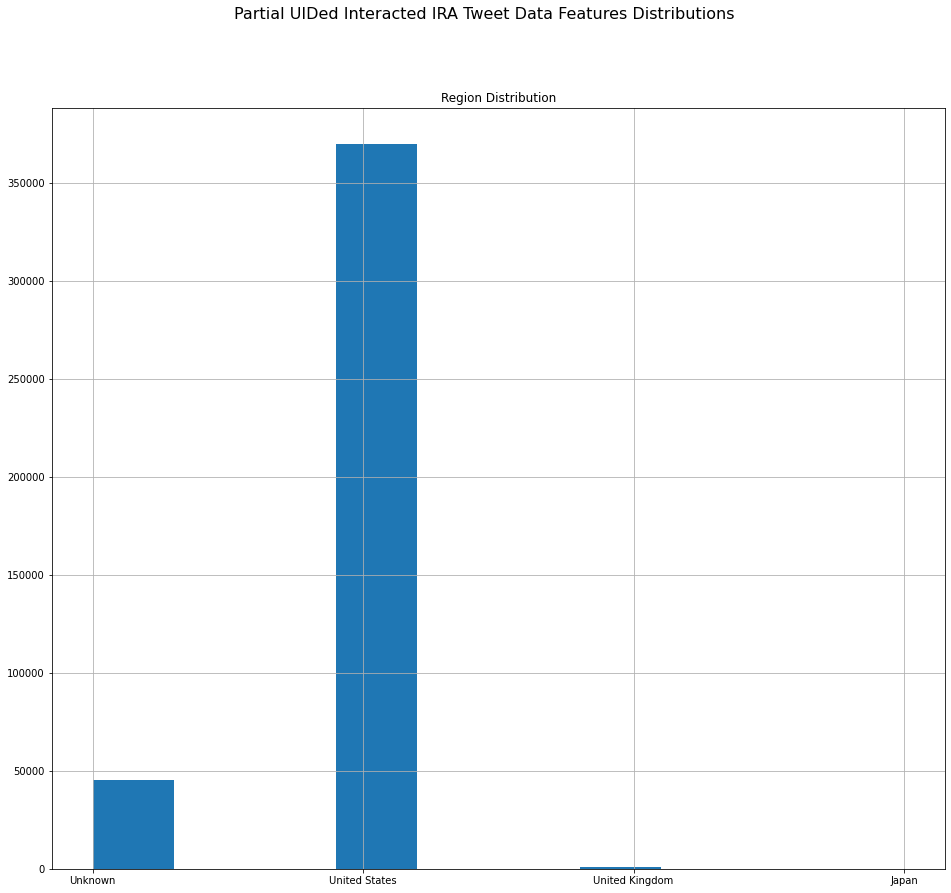

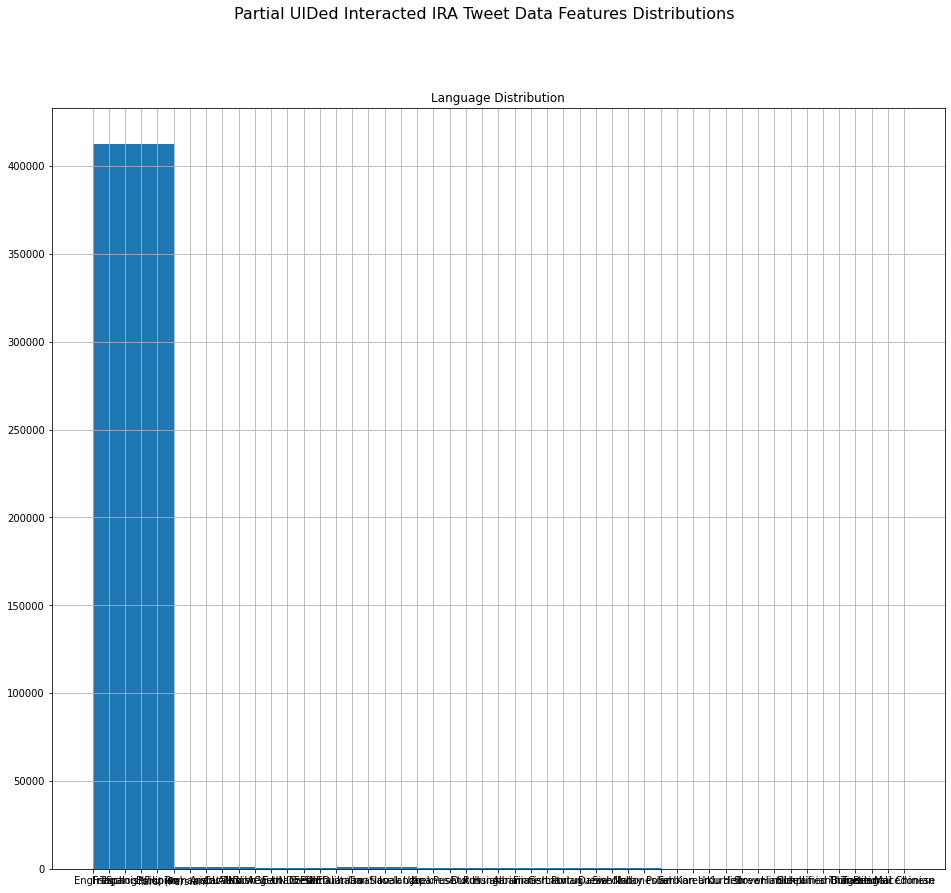

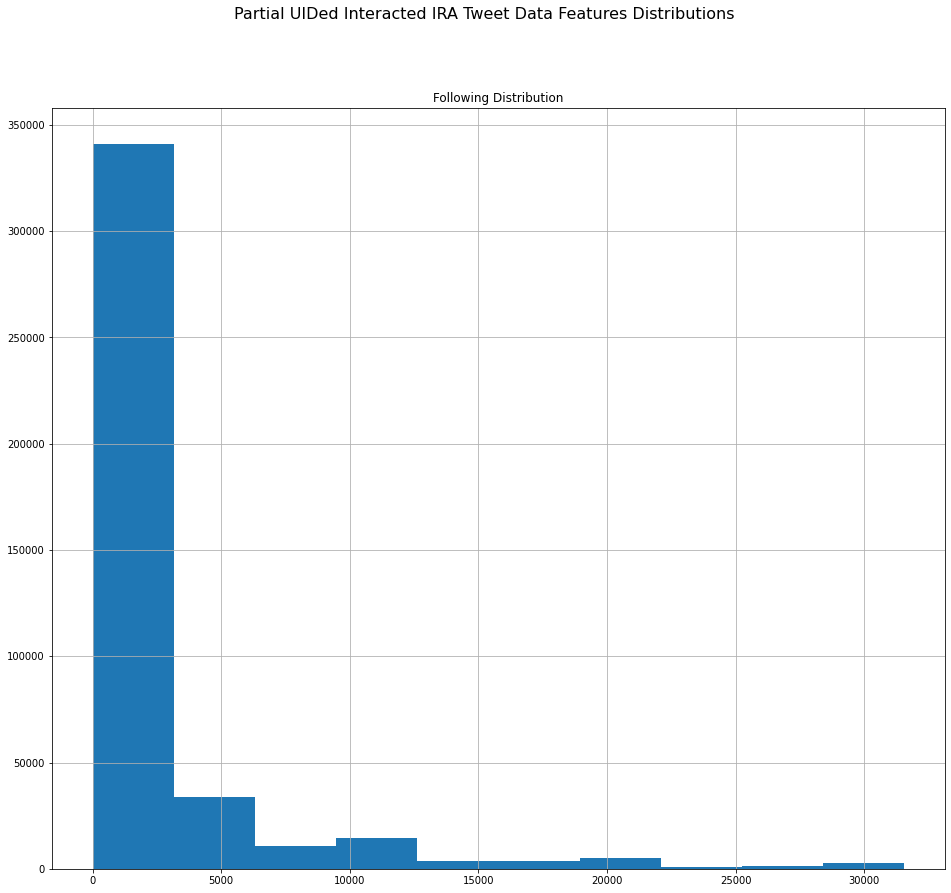

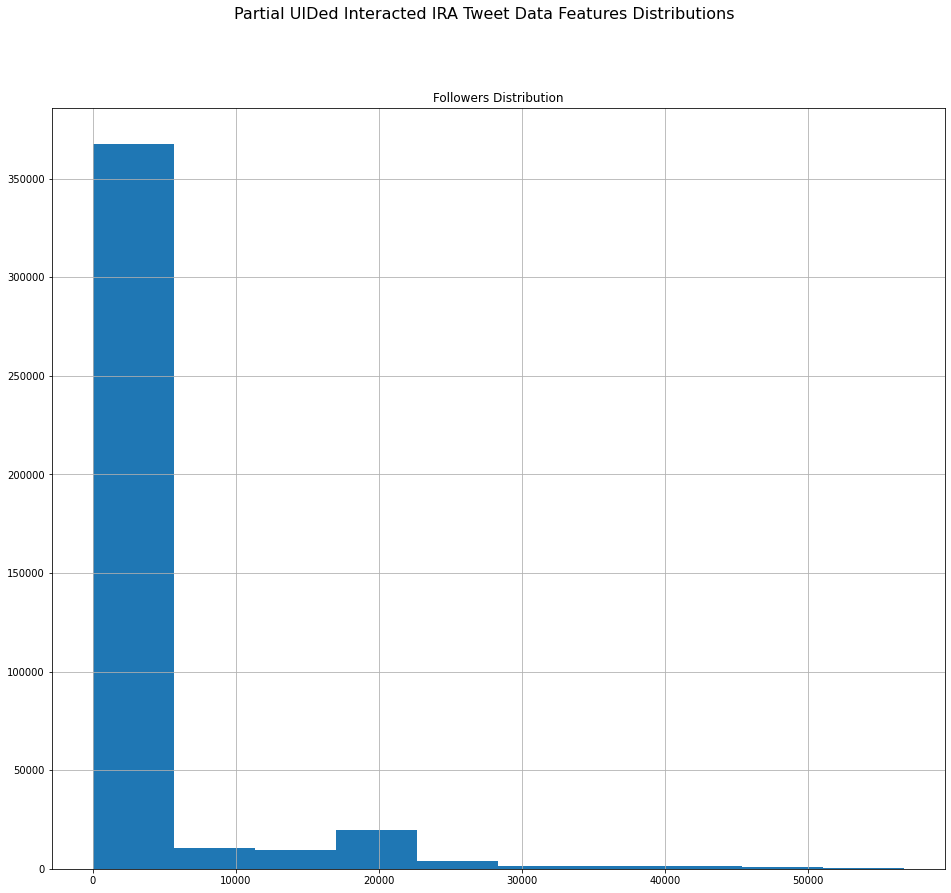

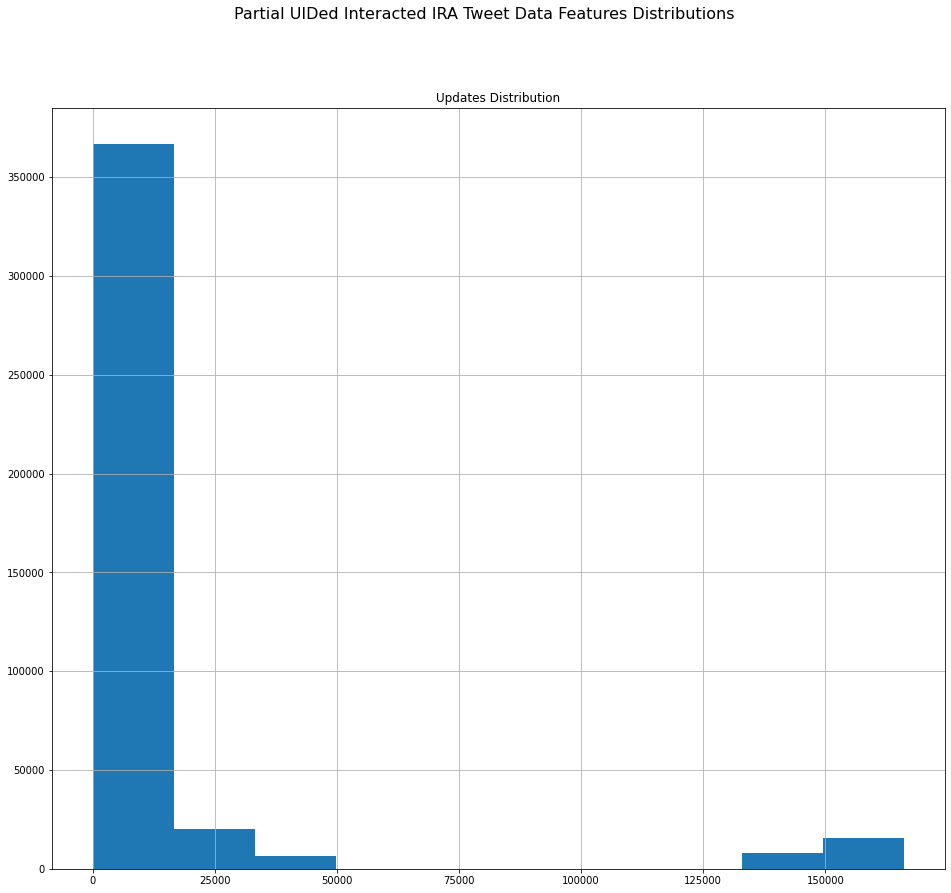

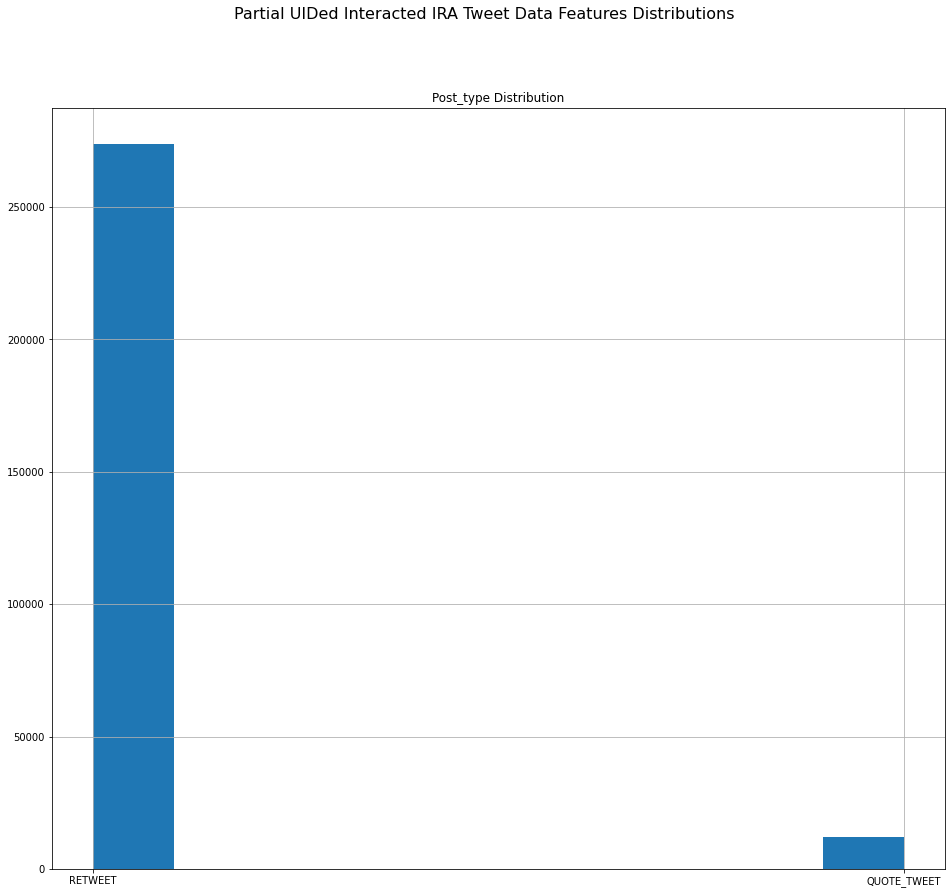

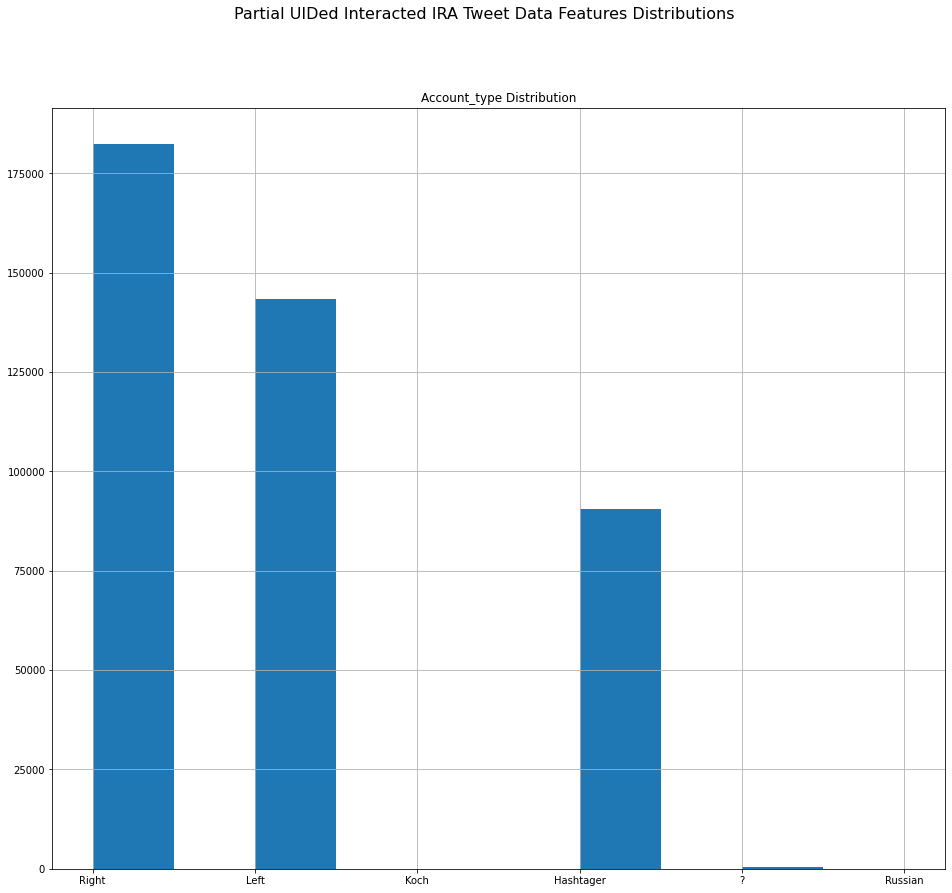

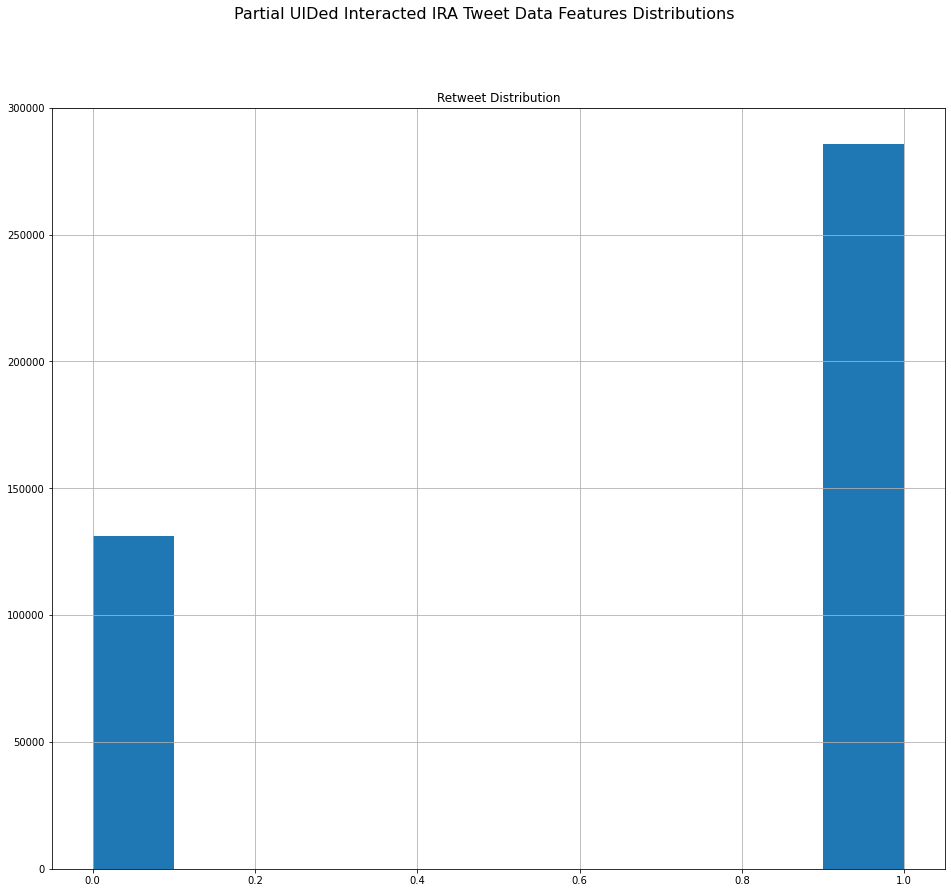

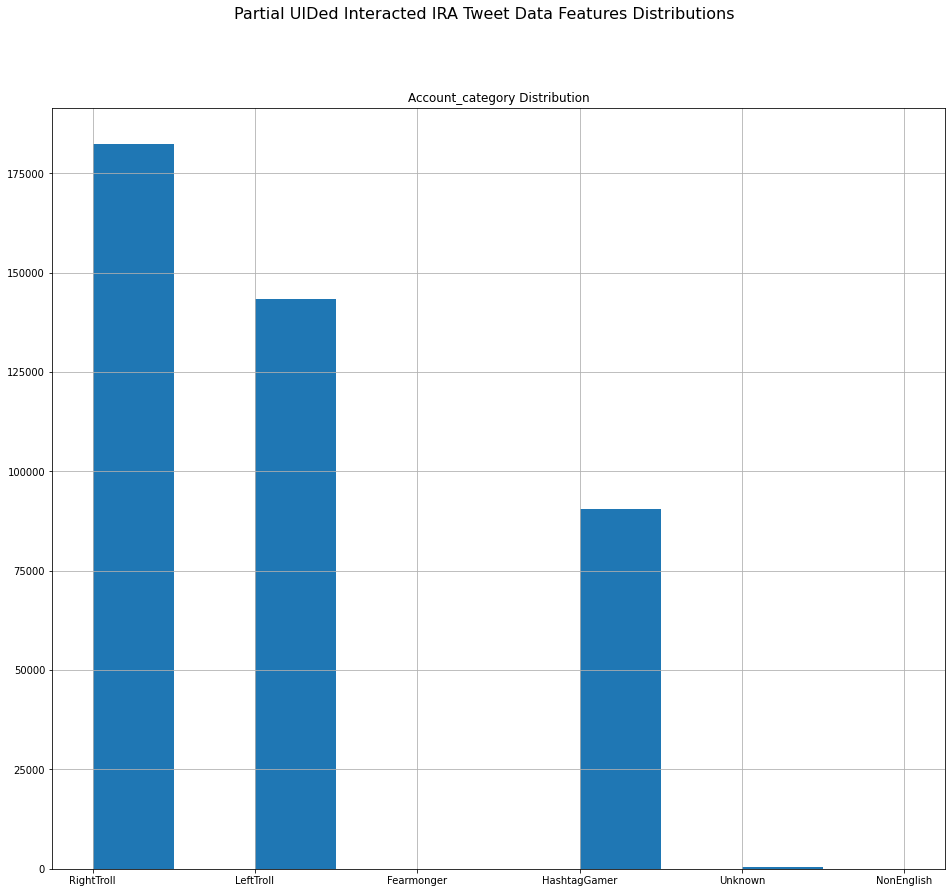

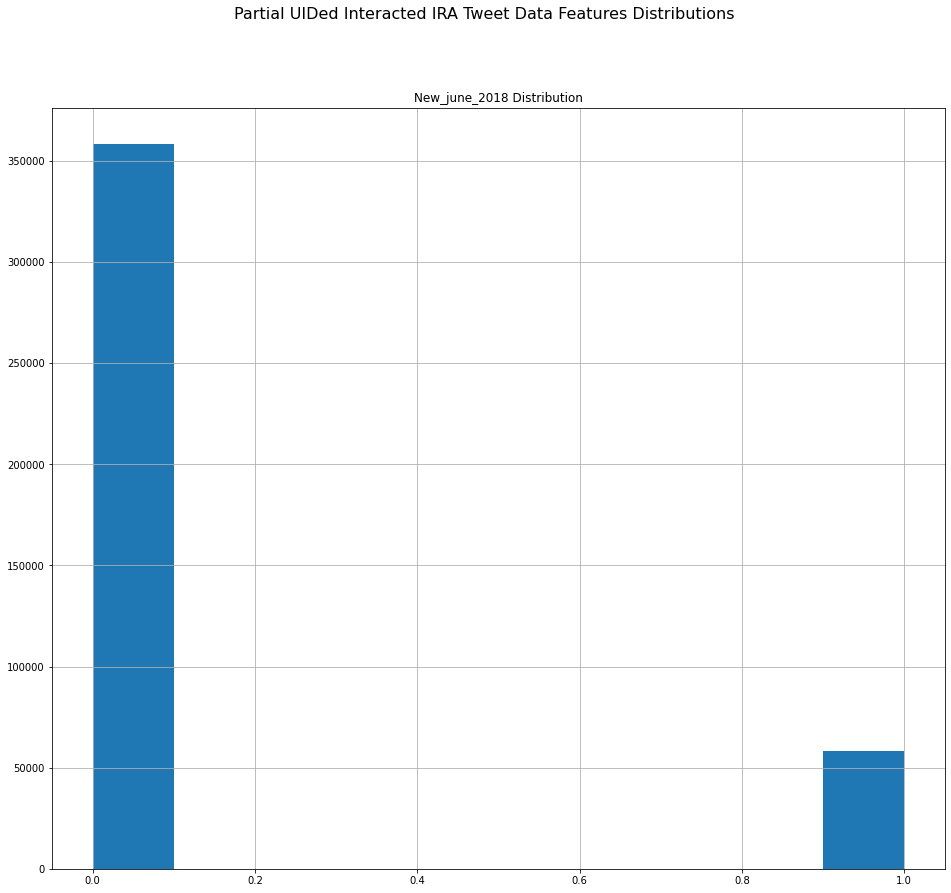

In [ ]:
from matplotlib import pyplot as plt
from typing import List

# pub_dates = pd.to_datetime(df['publish_date']).dt

# df['pub_year'] = pub_dates.year.astype(np.int16)
# df['pub_month'] = pub_dates.month.astype(np.int16)
# df['pub_my'] = df['pub_year'].astype(str) + df['pub_month'].astype(str)

# har_dates = pd.to_datetime(df['harvested_date']).dt

# df['har_year'] = har_dates.year.astype(np.int16)
# df['har_month'] = har_dates.month.astype(np.int16)
# df['har_my'] = df['har_year'].astype(str) + df['har_month'].astype(str)

def plot_histograms(df: pd.DataFrame, cols2visualize: List[str], title: str):
    """
    plot hist for data in given df for every given column
    :param df: (pd.DataFrame) the data to plot
    :param cols2visualize: (List[str]) list of column names to plot
    :param title: (str) title for the figure
    """
    for _col in cols2visualize:
        fig = plt.figure(figsize=(16, 14))
        fig.suptitle(title, fontsize=16)
        _ax = df[_col].hist()
        _ax.set_title(f"{_col.capitalize()} Distribution")
        plt.show()
        print()
        print()

cols_to_viz_dist = ['region', 'language', 'pub_year', 'pub_month', 
                    'pub_my', 'har_year', 'har_month', 'har_my', 'following', 
                    'followers', 'updates', 'post_type', 'account_type', 
                    'retweet', 'account_category', 'new_june_2018']

og_cols = cols_to_viz_dist[:2 ] +cols_to_viz_dist[8:]
titles = ['Partial UIDed Interacted IRA Tweet', 'Full UIDed Interacted IRA Tweet']
dfs_to_viz = [part_inter_ira]  # [part_inter_ira, ful_inter_ira]
for _ttl, _df in zip(titles, dfs_to_viz):
    print(_ttl)
    plot_histograms(_df, og_cols, f"{_ttl} Data Features Distributions")

Partial UIDed Interacted IRA Tweet



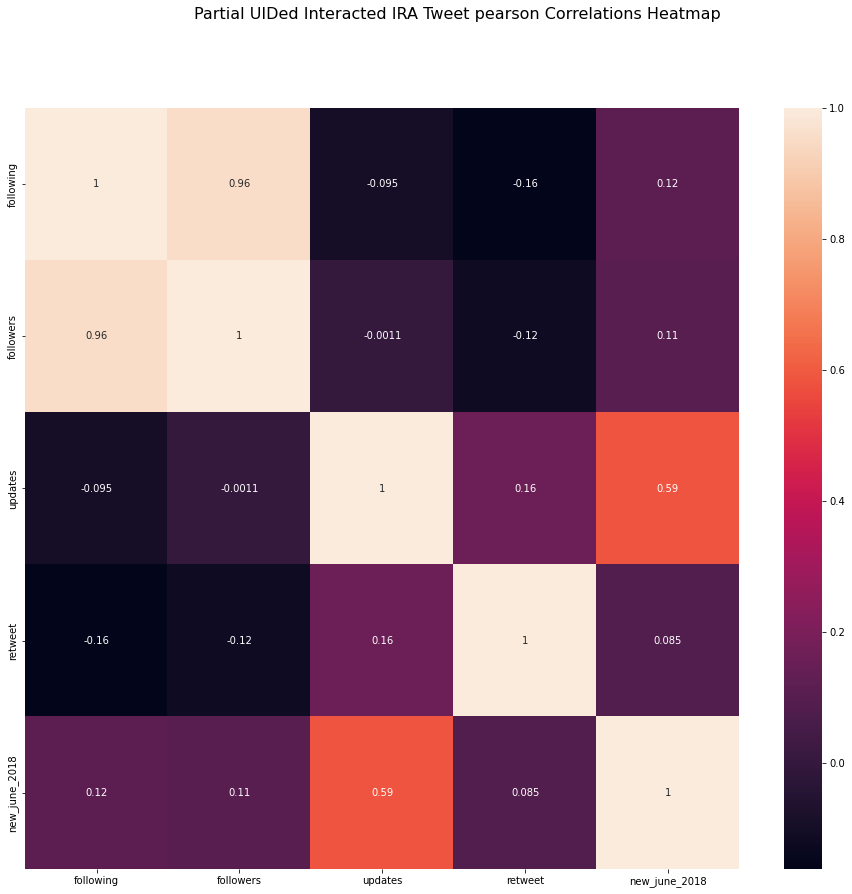




Partial UIDed Interacted IRA Tweet



/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


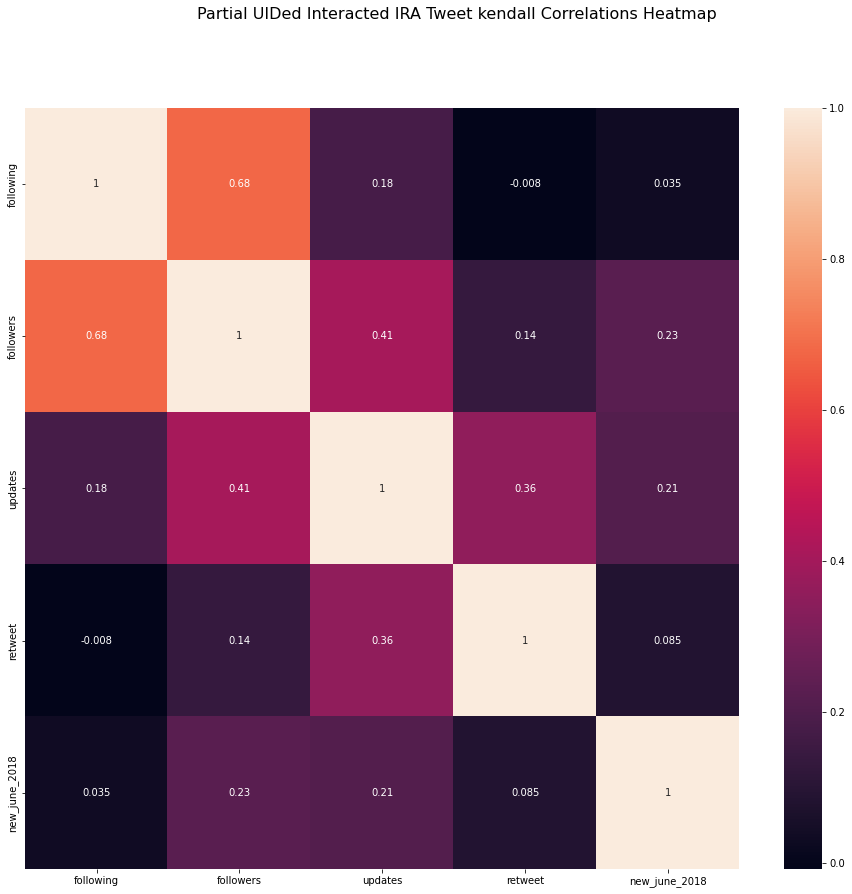




Partial UIDed Interacted IRA Tweet



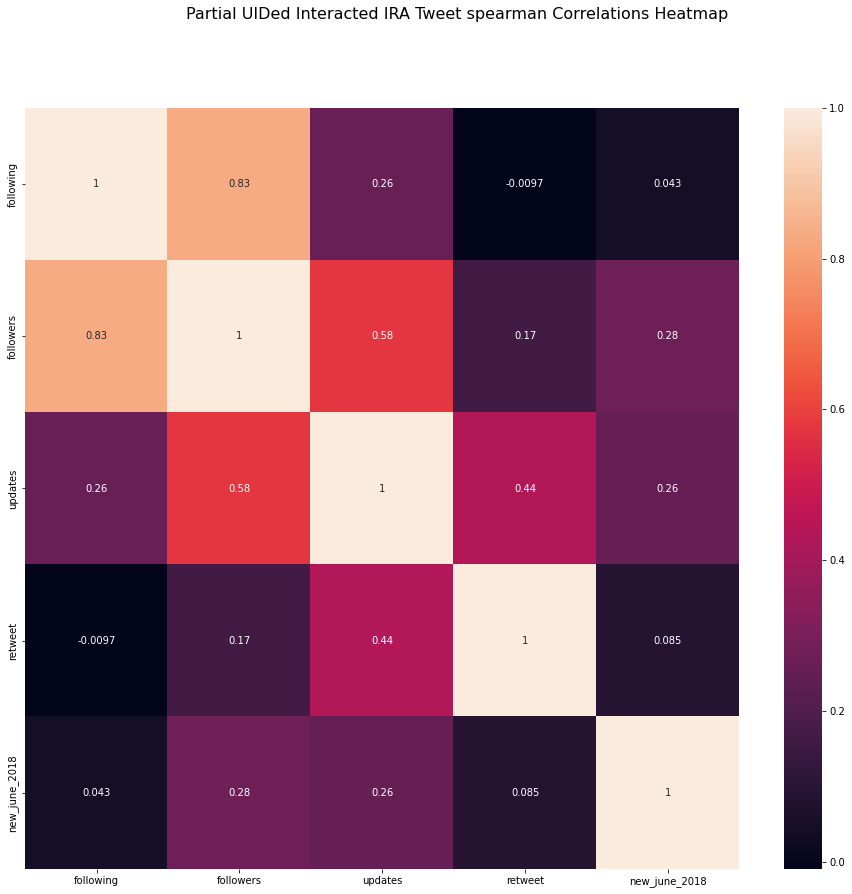

In [ ]:
import seaborn as sns


def plot_corr_heatmap(df: pd.DataFrame, cols2viz: List[str], title: str, method: str='pearson') -> pd.DataFrame:
    """
    plot correlation heatmap
    :param df: (pd.DataFrame) the dataframe to plot correlations
    :param cols2viz: (List[str]) list of column names to correlate
    :param title: (str) the title of the figure
    :param method: (str) correlation method
    :return: (pd.DataFrame) correlations data
    """
    corr_data = df[cols2viz].corr(method=method)
    fig = plt.figure(figsize=(16, 14))
    fig.suptitle(title, fontsize=16)
    sns.heatmap(corr_data, annot=True)
    return corr_data




corr_methods = ('pearson', 'kendall', 'spearman')
corr_dfs_dict = {k: dict() for k in corr_methods}
for mtd in corr_methods:
    for _ttl, _df in zip(titles, dfs_to_viz):
        print(_ttl)
        print()
        corr_dfs_dict[mtd][_ttl] = plot_corr_heatmap(_df, og_cols, f"{_ttl} {mtd} Correlations Heatmap", method=mtd)
        corr_dfs_dict[mtd][_ttl].index.name = _ttl
        plt.show()
        print()
        print()
        print()

In [ ]:
from IPython.display import display as df_display


for _mtd, _dct in corr_dfs_dict.items():
    for _name, _df in _dct.items():
        _cdf = pd.DataFrame(np.tril(_df.abs(), k=-1), columns=_df.columns, index=_df.columns)
        print(_name)
        print()
        df_display(_cdf)
        print()
        print()


# for _df, _name in zip(dfs_to_viz, titles):
#     _cdf = pd.DataFrame(np.tril(_df[og_cols].corr().abs(), k=-1), columns=_df[og_cols].corr().columns, index=_df[og_cols].corr().columns)
#     _cdf.index.name = _name
#     print(_name)
#     print()
#     df_display(_cdf)
#     print()
#     print()

Partial UIDed Interacted IRA Tweet



,following,followers,updates,retweet,new_june_2018
following,0.000000,0.000000,0.000000,0.00000,0.0
followers,0.957105,0.000000,0.000000,0.00000,0.0
updates,0.095045,0.001100,0.000000,0.00000,0.0
retweet,0.161961,0.118404,0.159052,0.00000,0.0
new_june_2018,0.116578,0.109058,0.586939,0.08539,0.0




Partial UIDed Interacted IRA Tweet



,following,followers,updates,retweet,new_june_2018
following,0.000000,0.000000,0.000000,0.00000,0.0
followers,0.679286,0.000000,0.000000,0.00000,0.0
updates,0.177424,0.408552,0.000000,0.00000,0.0
retweet,0.007966,0.135456,0.355824,0.00000,0.0
new_june_2018,0.034887,0.225921,0.209568,0.08539,0.0




Partial UIDed Interacted IRA Tweet



,following,followers,updates,retweet,new_june_2018
following,0.000000,0.000000,0.000000,0.00000,0.0
followers,0.833296,0.000000,0.000000,0.00000,0.0
updates,0.262307,0.575978,0.000000,0.00000,0.0
retweet,0.009737,0.165794,0.435774,0.00000,0.0
new_june_2018,0.042642,0.276520,0.256656,0.08539,0.0


In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# vectorizer.fit_transform(df['content'].fillna(''))
# print(vectorizer.vocabulary)
# len(vectorizer.vocabulary_), sum(vectorizer.vocabulary_.values())

In [ ]:
pu_ira_path = os.path.join(PREPROCESSED_DIR_PATH, 'part_uid_inter_ira.csv')
pira_df = pd.read_csv(pu_ira_path)
pira_df.head()

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,...,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1,UID
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,...,0,RightTroll,0,9.058747e+17,9.145804e+17,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN,197
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,...,0,RightTroll,0,9.058747e+17,9.146218e+17,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN,197
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,...,1,RightTroll,0,9.058747e+17,9.146235e+17,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/913231923715...,NaN,NaN,197
3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,...,0,RightTroll,0,9.058747e+17,9.146391e+17,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914639143690...,NaN,NaN,197
4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,...,1,RightTroll,0,9.058747e+17,9.143122e+17,http://twitter.com/905874659358453760/statuses...,https://twitter.com/realDonaldTrump/status/914...,NaN,NaN,197


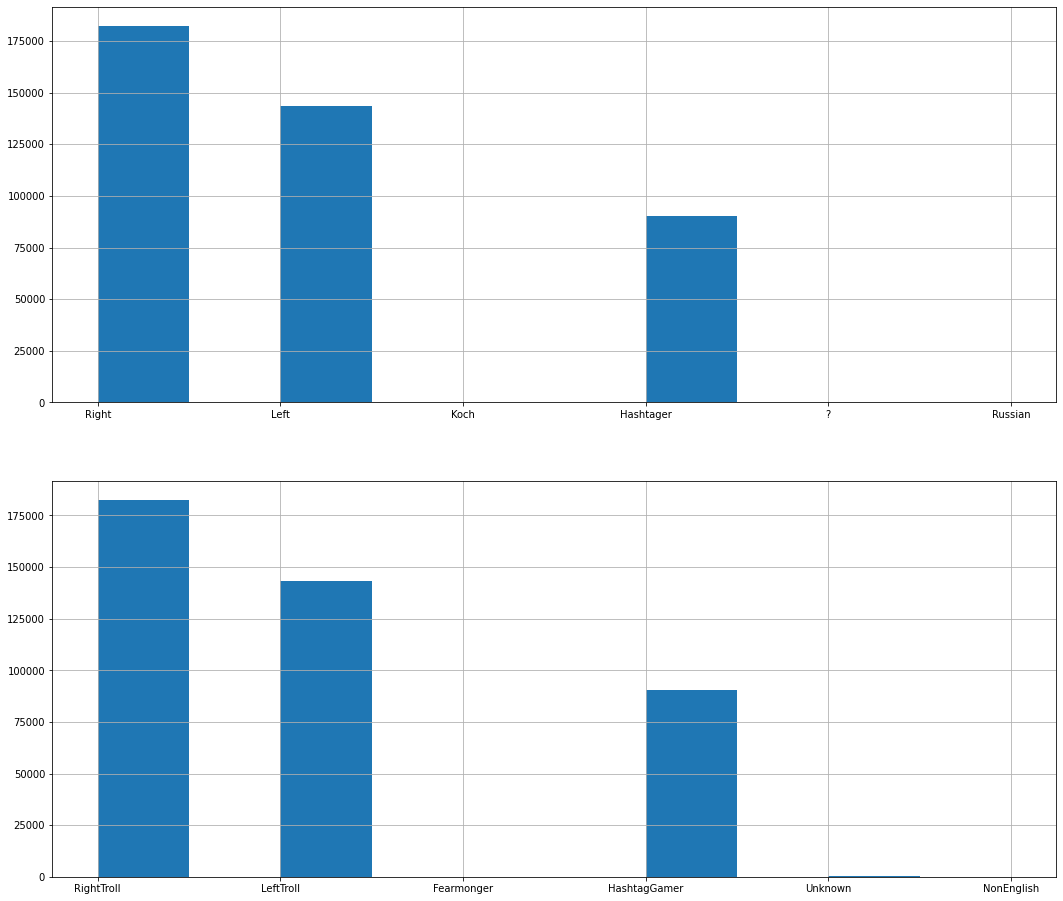

In [ ]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(18, 16))
pira_df['account_type'].hist(ax=axes[0])
pira_df['account_category'].hist(ax=axes[1])
plt.show()

In [ ]:
mark = os.linesep +  '-' * 50 + os.linesep
print("PIRA Account Type")
print()
print(pira_df['account_type'].value_counts())
print(mark)
print("IRA Account Type")
print()
print(ira_df['account_type'].value_counts())
print(mark)
print("PIRA Account Category")
print()
print(pira_df['account_category'].value_counts())
print(mark)
print("IRA Account Category")
print()
print(ira_df['account_category'].value_counts())

PIRA Account Type

Right        182370
Left         143479
Hashtager     90492
?               385
Russian          35
Koch              4
Name: account_type, dtype: int64

--------------------------------------------------

IRA Account Type

Russian       662050
Right         629625
local         359957
left          257945
Hashtager     200929
Left          144034
news          136646
German         80469
Italian        14252
Commercial     13700
?              13187
Koch            8620
Arabic          6228
Spanish         1254
French          1097
ZAPOROSHIA       175
Portuguese       118
Ebola             71
Ukranian           4
Name: account_type, dtype: int64

--------------------------------------------------

PIRA Account Category

RightTroll      182370
LeftTroll       143479
HashtagGamer     90492
Unknown            385
NonEnglish          35
Fearmonger           4
Name: account_category, dtype: int64

--------------------------------------------------

IRA Account Category


## Degrees' distributions for account_types

In [ ]:
joined_df = pd.read_csv(r"/content/drive/MyDrive/NLP_And_Social_Dynamics/Data/preprocessed_data/joined_users_dataset.csv")
print(joined_df.shape)
joined_df.head()

(231981, 36)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,7,9,33) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,tweet_id,userid_hash,user_screen_name_hash,final_profile_description,followers_mis,tweet_time,retweet_userid,in_reply_to_userid,account_type_mis,rt_atype,...,retweet,account_category,new_june_2018,alt_external_id,article_url,tco1_step1,tco2_step1,tco3_step1,target_id,target_type
0,552475834658086912,71db45e4783602194ced17d50c4070036dfc754e9557fe...,71db45e4783602194ced17d50c4070036dfc754e9557fe...,"Very outspoken, but don't take it for anger. x...",64.0,2015-01-06 14:44,NaN,NaN,LeftTroll,NaN,...,0,LeftTroll,0,1.652139e+09,http://twitter.com/acejinev/statuses/552475834...,NaN,NaN,NaN,not_inter,not_inter
1,552475784288690176,71db45e4783602194ced17d50c4070036dfc754e9557fe...,71db45e4783602194ced17d50c4070036dfc754e9557fe...,"Very outspoken, but don't take it for anger. x...",64.0,2015-01-06 14:44,NaN,NaN,LeftTroll,NaN,...,0,LeftTroll,0,1.652139e+09,http://twitter.com/acejinev/statuses/552475784...,NaN,NaN,NaN,not_inter,not_inter
2,552475721374121984,ef983249ef6ed5de427c4dc19ad6d966c6cf572c2505e4...,ef983249ef6ed5de427c4dc19ad6d966c6cf572c2505e4...,Fun-loving conservative sharing the truth that...,60.0,2015-01-06 14:44,NaN,NaN,RightTroll,NaN,...,0,RightTroll,0,1.629828e+09,http://twitter.com/cassishere/statuses/5524757...,NaN,NaN,NaN,not_inter,not_inter
3,552475758896353280,ef983249ef6ed5de427c4dc19ad6d966c6cf572c2505e4...,ef983249ef6ed5de427c4dc19ad6d966c6cf572c2505e4...,Fun-loving conservative sharing the truth that...,60.0,2015-01-06 14:44,NaN,NaN,RightTroll,NaN,...,0,RightTroll,0,1.629828e+09,http://twitter.com/cassishere/statuses/5524757...,NaN,NaN,NaN,not_inter,not_inter
4,552475998676348928,71db45e4783602194ced17d50c4070036dfc754e9557fe...,71db45e4783602194ced17d50c4070036dfc754e9557fe...,"Very outspoken, but don't take it for anger. x...",64.0,2015-01-06 14:45,NaN,NaN,LeftTroll,NaN,...,0,LeftTroll,0,1.652139e+09,http://twitter.com/acejinev/statuses/552475998...,NaN,NaN,NaN,not_inter,not_inter


In [ ]:
joined_df['target_type'] = joined_df['target_type'].fillna('allegedly_legit')
rel_df = joined_df[joined_df['target_id'] != 'not_inter']

In [ ]:
unq_srcs, unq_tgts = rel_df['account_type_mis'].unique(), rel_df['target_type'].unique()

In [ ]:
adj_mat_size = (unq_srcs.shape[0], unq_tgts.shape[0])
adj_mat = np.zeros(adj_mat_size, dtype=np.int32)
comm_df = pd.DataFrame(adj_mat, index=list(unq_srcs), columns=list(unq_tgts))
comm_df

,LeftTroll,Fearmonger,allegedly_legit,HashtagGamer,Newsfeed,RightTroll,Unknown
LeftTroll,0,0,0,0,0,0,0
HashtagGamer,0,0,0,0,0,0,0
RightTroll,0,0,0,0,0,0,0


In [ ]:
rel_df[(rel_df['account_type_mis'] == 'LeftTroll') & (rel_df['target_type'] == 'LeftTroll')].shape

(2482, 36)

In [ ]:
for i, atype in enumerate(unq_srcs):
    for j, btype in enumerate(unq_tgts):
        comm_count = rel_df[(rel_df['account_type_mis'] == atype) & (rel_df['target_type'] == btype)].shape[0]
        adj_mat[i, j] = comm_count

# adj_mat[-1, -1] = -1
adj_mat

array([[ 2482,     3, 62821,    50,  2762,    65,     0],
       [   18,    41, 36286,  5067,    13,   129,     1],
       [   28,     1, 59996,   137,  7236,   945,     3]], dtype=int32)

In [ ]:
comm_df = pd.DataFrame(adj_mat, index=list(unq_srcs), columns=list(unq_tgts))
comm_df

,LeftTroll,Fearmonger,allegedly_legit,HashtagGamer,Newsfeed,RightTroll,Unknown
LeftTroll,2482,3,62821,50,2762,65,0
HashtagGamer,18,41,36286,5067,13,129,1
RightTroll,28,1,59996,137,7236,945,3


In [ ]:
fig = px.imshow(comm_df, text_auto=True)
fig.update_layout(xaxis_title=f"Target of interaction", 
                  yaxis_title='Source of interaction', 
                  title_text='Distribution of communication between account types', 
                  title_x=0.5, 
                  font={'size': 14}
                  )
fig.show()

In [ ]:
fig.write_image(r"/content/drive/MyDrive/NLP_And_Social_Dynamics/plots/inter_atypes_communication_heatmap.png")

In [ ]:
for idx in comm_df.index.unique():
    fig = px.bar(comm_df.loc[idx], title=f"Communication Bar Plot, {idx}")
    fig.show()
    fig.write_image(f"/content/drive/MyDrive/NLP_And_Social_Dynamics/plots/inter_atypes({idx}2all)_communication_barplot.png")

## Normalized communication between different types of accounts

In [ ]:
src_norm_mat = adj_mat.copy().T.astype(np.float32)
src_norm_mat = (src_norm_mat / src_norm_mat.sum(axis=0)).T
tgt_norm_mat = adj_mat.copy().astype(np.float32)
tgt_norm_mat = tgt_norm_mat / tgt_norm_mat.sum(axis=0)
# src_norm_mat = adj_mat.copy().astype(np.float32)
# src_norm_mat = (src_norm_mat.T / src_norm_mat.sum(axis=1)).T
# tgt_norm_mat = adj_mat.copy().astype(np.float32)
# tgt_norm_mat = tgt_norm_mat / tgt_norm_mat.sum(axis=0)

# for i in range(src_norm_mat.shape[0]):
#     src_norm_mat[i, :] /= src_norm_mat[i, :].sum()

# for j in range(tgt_norm_mat.shape[1]):
#     tgt_norm_mat[:, j] /= tgt_norm_mat[:, j].sum()

In [ ]:
src_norm_comm_df = pd.DataFrame(src_norm_mat, index=unq_srcs, columns=unq_tgts)
tgt_norm_comm_df = pd.DataFrame(tgt_norm_mat, index=unq_srcs, columns=unq_tgts)
src_norm_comm_df

,LeftTroll,Fearmonger,allegedly_legit,HashtagGamer,Newsfeed,RightTroll,Unknown
LeftTroll,0.036402,0.000044,0.921359,0.000733,0.040509,0.000953,0.000000
HashtagGamer,0.000433,0.000987,0.873204,0.121935,0.000313,0.003104,0.000024
RightTroll,0.000410,0.000015,0.877828,0.002005,0.105873,0.013827,0.000044


In [ ]:
# for col in src_norm_comm_df.columns:
#     src_ttype = src_norm_comm_df[col]
#     tgt_ttype = tgt_norm_comm_df[col]
#     src_ttype = src_ttype.apply(lambda x: str(round(x, 3)) + '%')
#     tgt_ttype = tgt_ttype.apply(lambda x: str(round(x, 3)) + '%')
#     src_norm_comm_df[col] = src_ttype
#     tgt_norm_comm_df[col] = tgt_ttype

# src_norm_comm_df

,LeftTroll,Fearmonger,allegedly_legit,HashtagGamer,Newsfeed,RightTroll,Unknown
LeftTroll,3.64%,0.004%,92.136%,0.073%,4.051%,0.095%,0.0%
HashtagGamer,0.043%,0.099%,87.32%,12.193%,0.031%,0.31%,0.002%
RightTroll,0.041%,0.001%,87.783%,0.2%,10.587%,1.383%,0.004%


In [ ]:
tgt_norm_comm_df

,LeftTroll,Fearmonger,allegedly_legit,HashtagGamer,Newsfeed,RightTroll,Unknown
LeftTroll,0.981804,0.066667,0.394845,0.009517,0.275897,0.057068,0.00
HashtagGamer,0.007120,0.911111,0.228066,0.964408,0.001299,0.113257,0.25
RightTroll,0.011076,0.022222,0.377089,0.026075,0.722805,0.829675,0.75


In [ ]:
fig = px.imshow(src_norm_comm_df, text_auto='.3%')
fig.update_layout(xaxis_title=f"Target of interaction", 
                  yaxis_title='Source of interaction', 
                  title_text='Distribution of communication between account types (normalized by source)', 
                  title_x=0.5, 
                  font={'size': 14}
                  )
fig.show()
fig.write_image(r"/content/drive/MyDrive/NLP_And_Social_Dynamics/plots/inter_atypes_communication_source_normalized_heatmap.png")

In [ ]:
fig = px.imshow(tgt_norm_comm_df, text_auto='.3%')
fig.update_layout(xaxis_title=f"Target of interaction", 
                  yaxis_title='Source of interaction', 
                  title_text='Distribution of communication between account types (normalized by target)', 
                  title_x=0.5, 
                  font={'size': 14}
                  )
fig.show()
fig.write_image(r"/content/drive/MyDrive/NLP_And_Social_Dynamics/plots/inter_atypes_communication_target_normalized_heatmap.png")

In [ ]:
for idx in comm_df.index.unique():
    fig = px.bar(src_norm_comm_df.loc[idx], title=f"Communication Bar Plot, {idx} (source normalized)")
    fig.show()
    fig.write_image(f"/content/drive/MyDrive/NLP_And_Social_Dynamics/plots/inter_atypes({idx}2all)_communication_source_normalized_barplot.png")

In [ ]:
for idx in comm_df.index.unique():
    fig = px.bar(tgt_norm_comm_df.loc[idx], title=f"Communication Bar Plot, {idx} (target normalized)")
    fig.show()
    fig.write_image(f"/content/drive/MyDrive/NLP_And_Social_Dynamics/plots/inter_atypes({idx}2all)_communication_target_normalized_barplot.png")

# Graph Building Functions

given df, each node is a user with its features

each edge has features + weight

returns nx-DiGraph

user = UID:
  - author (?)
  - content (?)
  - region
  - language(s)
  - following
  - followers
  - account_type
  - count_retweet
  - count_retweeted
  - account_category
  - count_tweets
  - avg_sentiment
  - count_quoteTweet

connection = interactions between users:
  - count_mentions
  - count_retweets
  - avg_sentiment (?)

In [ ]:
afn = Afinn()

def count_interacted(user_id: int, data: pd.DataFrame) -> int:
    """
    count how many times users interacted with the given user.
    :param user_id: (int) the user given id 
    :param data: (pd.DataFrame) the dataframe of all the relevant interactions
    :return: (int) the number of interactions from other users to given user
    """
    res = data.loc[data['iUID'] == str(user_id)].shape[0]
    return res

def count_interacted_by(user_id: int, data: pd.DataFrame, kind: str) -> int:
    """
    count how many times users retweeted the given user.
    :param user_id: (int) the user given id 
    :param data: (pd.DataFrame) the dataframe of all the relevant interactions
    :param kind: (str) kind of the interactions (retweet or reply)
    :return: (int) the number of retweets to given user
    """
    _kind = 'in_reply_to_userid' if ('reply' in kind) else 'retweet_userid' if ('retweet' in kind) else 'None'
    if _kind == 'None':
        raise ValueError(f"{kind} is not an interaction")
    res = data.loc[(data['iUID'] == str(user_id)) & (~data[_kind].isnull())].shape[0]
    return res

def get_sentiments(tweets: np.ndarray, methods: List[str]) -> Dict[str, np.number]:
    """
    calculates sentiments by given aggregation methods for given tweets.
    UserWarning for any method that is not np.ndarray's method
    :param tweets: (np.ndarray) the tweets
    :param methods: List[str] list of all the aggregation methods for the tweets' sentiments
    :return: (Dict[str, np.number]) for each method(key) has its values
    """
    sentiments = np.array(list(map(afn.score, tweets)))
    atrs = dir(sentiments)
    np_atrs = dir(np)
    results = {}
    for method in methods:
        if method not in atrs:
            if method not in np_atrs:
                warnings.warn(f"can't aggregate {method} from numpy array")
            else:
                results[method] = getattr(sentiments, method)(sentiments)
                
        else:
            results[method] = getattr(sentiments, method)()
    return results

def get_users_features_dict(user_id: int, data: pd.DataFrame, interactions_data: pd.DataFrame) -> dict:
    """
    calculates users features and return as a dictionary
    :param user_id: (int) the user id
    :param data: (pd.DataFrame) the data to extract the features from
    :param interactions_data: (pd.DataFrame) the data of all interactions
    :return: (dict) the features of the users (keys: str=feature's name, values)
    """
    user_df = data.loc[data['UID'] == user_id]
    if any(['txt_embedding' in x for x in user_df.columns]):
        user_embs = user_df[[f"txt_embedding_{i}" for i in range(300)]].mean().to_numpy()
    else:
        user_embs = -np.ones((300, ))

    features = {}
    features['tweet_emb'] = user_embs
    features['md_region'] = user_df['region'].mode().values[0]
    features['num_regions'] = user_df['region'].unique().shape[0]
    features['md_language'] = user_df['language'].mode().values[0]
    features['num_languages'] = user_df['language'].unique().shape[0]
    features['max_following'] = user_df['following'].max()
    features['mean_following'] = user_df['following'].mean()
    features['max_followers'] = user_df['followers'].max()
    features['mean_followers'] = user_df['followers'].mean()
    features['account_type'] = user_df['account_type'].mode().values[0]
    features['new_june_2018'] = user_df['new_june_2018'].max()
    features['count_retweet'] = user_df['retweet'].sum()
    features['count_retweeted'] = count_interacted_by(user_id, data, 'retweet')
    features['count_reply'] = count_interacted_by(user_id, data, 'reply')
    features['count_interacted'] = features['count_reply'] + features['count_retweeted']
    features['md_account_category'] = user_df['account_category'].mode().values[0]
    features['count_tweets'] = user_df.shape[0]
    features['count_quotes'] = user_df[user_df['post_type'] == 'QUOTE_TWEET'].shape[0]
    mtds = ['max', 'min', 'mean', 'median', 'sum']
    mtds_sents = get_sentiments(user_df['content'].values, mtds)
    for k, v in mtds_sents.items():
        features[f"{k}_sentiment"] = v
    
    return features

In [ ]:
def count_edge_interacted_by(data: pd.DataFrame, kind: str) -> int:
    """
    count how many times to users interacted.
    :param data: (pd.DataFrame) the dataframe of interactions between the users.
    :param kind: (str) kind of the interactions (retweet or reply)
    :return: (int) the number of interactions from other users to given user.
    """
    _kind = 'in_reply_to_userid' if ('reply' in kind) else 'retweet_userid' if ('retweet' in kind) else 'None'
    if _kind == 'None':
        raise ValueError(f"{kind} is not an interaction")
    res = data[~data[_kind].isnull()].shape[0]
    return res

def get_edge_sentiments(twts_data: pd.DataFrame, inter_data: pd.DataFrame, methods: List[str]) -> Dict[str, np.number]:
    """
    calculates sentiments by given aggregation methods for tweets between tgt_user_id to src_user_id.
    UserWarning for any method that is not np.ndarray's method
    :param twts_data: (pd.DataFrame) the dataframe of all the tweets.
    :param inter_data: (pd.DataFrame) the dataframe of the interactions between the users.
    :param methods: List[str] list of all the aggregation methods for the tweets' sentiments.
    :return: (Dict[str, np.number]) for each method(key) has its values.
    """
    inter_tweet_ids = inter_data['tweet_id'].values
    tweets = twts_data.loc[twts_data['tweet_id'].isin(inter_tweet_ids), 'content'].values
    sentiments = np.array(list(map(afn.score, tweets)))
    atrs = dir(sentiments)
    np_atrs = dir(np)
    results = {}
    for method in methods:
        if method not in atrs:
            if method not in np_atrs:
                warnings.warn(f"can't aggregate {method} from numpy array")
            else:
                results[method] = getattr(sentiments, method)(sentiments)
                
        else:
            results[method] = getattr(sentiments, method)()
    return results

def get_interactions_features_dict(src_user_id: int, tgt_user_id: int, data: pd.DataFrame, interactions_data: pd.DataFrame) -> Dict[str, np.number]:
    """
    calculates interactions features and return as a dictionary
    :param src_user_id: (int) the source user id.
    :param tgt_user_id: (int) the user id of the user who responded.
    :param data: (pd.DataFrame) the data of the tweets
    :param interactions_data: (pd.DataFrame) the data of all interactions
    :return: (Dict[str, np.number]) the features of the interactions (keys: str=feature's name, values)
    """
    interactions_df = interactions_data.loc[(interactions_data['UID'] == str(tgt_user_id)) & (interactions_data['iUID'] == str(src_user_id))]
    features = {}
    features['count_retweets'] = count_edge_interacted_by(interactions_df, 'retweet')
    features['count_replies'] = count_edge_interacted_by(interactions_df, 'reply')
    features['count_interactions'] = features['count_replies'] + features['count_retweets']
    mtds = ['max', 'min', 'mean', 'median', 'sum']
    mtds_sents = get_edge_sentiments(data, interactions_df, mtds)
    for k, v in mtds_sents.items():
        features[f"{k}_sentiment"] = v
    
    return features

# for each user, get node (user, get_users_features_dict)
# for each interaction, get edge (src_user, tgt_user, get_edges_features_dict)
# create DiGraph with nodes and edges.

In [ ]:
def get_nodes(data: pd.DataFrame, inter_data: pd.DataFrame, verbose: bool=True) -> List[tuple]:
    """
    given tweets dataframe and interactions dataframe return the list of the nodes (users)
    :param data: (pd.DataFrame) the tweets dataframe
    :param inter_data: (pd.DataFrame) the interactions dataframe
    :param verbose: (bool) rather to show progress bar
    :return: (List[tuple]) the users as nodes
    """
    users_ids = data['UID'].unique().astype(int)
    nodes = [(user, get_users_features_dict(user, data, inter_data)) for user in tqdm(users_ids, desc='Prepare nodes from users', disable= not verbose)]
    return nodes


def get_edges(data: pd.DataFrame, inter_data: pd.DataFrame, verbose: bool=True) -> List[tuple]:
    """
    given the tweets dataframe and interactions dataframe return the list of the edges (interactions)
    :param data: (pd.DataFrame) the tweets dataframe
    :param inter_data: (pd.DataFrame) the interactions dataframe
    :param verbose: (bool) rather to show progress bar
    :return: (List[tuple]) the interaction between users as nodes
    """
    
    
def get_graph(data, inter_data, verbose):
  inter_data = inter_data.copy()
  if 'DansNan' in inter_data['iUID'].values:
      unknowns = inter_data.loc[inter_data['iUID'] == 'DansNan', ['in_reply_to_userid', 'retweet_userid']].values
      unknowns = np.hstack([unknowns[:, 0], unknowns[:, 1]])\
      unknowns = list(set([x for x in unknowns if isinstance(x, str)]))
      inter_data['iUID'] = inter_data['iUID'].apply(lambda x: -(unknowns.index(x)+1) if x == 'DansNan' else x)

In [ ]:
pmis['iUID'].values[0]

'DansNan'

In [ ]:
users_map['UID'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
pira_misinfo = pd.read_csv(r"/content/drive/MyDrive/NLP_And_Social_Dynamics/Data/preprocessed_data/part_uid_inter_misinfo.csv")
unknowns = pira_misinfo.loc[pira_misinfo['iUID'] == 'DansNan', ['in_reply_to_userid', 'retweet_userid']].values
unknowns = np.hstack([unknowns[:, 0], unknowns[:, 1]])
unknowns = list(set([x for x in unknowns if isinstance(x, str)]))
knowns = set(users_map['UID'].unique())
pmis = pira_misinfo.copy()
pmis['iUID_comp'] = pmis.apply(lambda row: row['iUID'] if row['iUID'] != 'DansNan' else row['in_reply_to_userid'] if np.isnan(row['retweet_userid']) else row['retweet_userid'], axis=1)
pmis['zb'] = pmis['iUID_comp'].apply(lambda x: x if x not in knowns else -(unknowns.index(x) + 1))

In [ ]:
pmis

85655

In [ ]:
pira_misinfo['iUID_comp'] = pira_misinfo.apply(lambda row: row['iUID'] if row['iUID'] != 'DansNan' else f"tmp_{row['in_reply_to_userid']}" if np.isnan(row['retweet_userid']) else f"tmp_{row['retweet_userid']}")
to_le = pira_misinfo['iUID_comp'].

unknowns = pira_misinfo.loc[pira_misinfo['iUID'] != 'DansNan', ['in_reply_to_userid', 'retweet_userid']]
unknowns = 

In [ ]:
users = df['external_author_id'].unique()
# interactions = [(src_user, tgt_user) for it_prod(users, users) if filter(only interactions)]
nodes = [(user, get_users_features_dict)for user in users]
# edges = [e + (get_edges_features_dict, ) for e in interactions]
network = nx.DiGraph()
network.add_nodes_from(nodes)
network.add_edges_from(edges)

In [ ]:
embdf = os.path.join(IRA_TWEETS, "IRAhandle_tweets_6_with_txt_embeddings.csv")
embdf = pd.read_csv(embdf)
embdf.head()

# Embeddings Analysis

## Embeddings Clustering and Visualizations Auxiliary Functions

In [ ]:
def add_hierarchical_clustering(n_clusters: List[int], emb_features: List[str], data: pd.DataFrame, verbose: bool=True) -> Tuple[pd.DataFrame, float, int]:
    """
    add hierarchical clusters to the data based on the embeddings and return the data with n_clusters columns.
    :param n_clusters: (List[int]) number of clustering to try.
    :param emb_features: (List[str]) embeddings column names.
    :param data: (pd.DataFrame) the data with the embeddings.
    :param verbose: (bool) print results (default verbose).
    :return: (Tuple[pd.DataFrame, dict, int]) the given data with the hierarchical columns, the best silhouette scores, the best n_clusters
    """
    embeddings = data[emb_features]
    silhouette_avgs = {}
    clusterer_kwargs = {'affinity': 'cosine', 'linkage': 'average'}
    best_sil, best_n_clusters = -1, None

    for n in tqdm(n_clusters, desc='Clustering and Evaluation', disable=not verbose):
        clusterer = AgglomerativeClustering(n_clusters=n, **clusterer_kwargs)
        k = f"{n}_clusters"
        if verbose:
            print(f"{k} fit predict")
        data[k] = clusterer.fit_predict(embeddings)
        silhouette_avgs[k] = silhouette_score(embeddings, data[k], metric='cosine')
        if silhouette_avgs[k] > best_sil:
            best_sil = silhouette_avgs[k]
            best_n_clusters = n

    if verbose:
        print(os.linesep.join([f"{x[0]}: {x[1]}" for x in sorted(silhouette_avgs.items(), key=lambda x: x[1], reverse=True)]))
    
    return data, silhouette_avgs, best_n_clusters


def get_tsne_dim_df(data: pd.DataFrame, cols: list=None, n_comp: int=2, verbose: bool=True) -> pd.DataFrame:
    """
    calculate the t-SNE values and return a dataframe with the components 
    "tsne{i}" for each i in n_comp 1-indexed range (tsne1, tsne2, etc..)
    the t-SNE method uses 'pca' as initialization method of the datapoints into 
    the new dimensionality and uses cosine similarity metric.
    :param data: (pd.DataFrame) the data to reduce the dimensions.
    :param cols: (list) list of columns to reduce (default=None -> all the data).
    :param n_comp: (int) the number of components to reduce the data (default=2).
    :param verbose: (bool) print process.
    :return: (pd.DataFrame) dataframe with the same columns (that did not enter to t-SNE)
      and new columns 'tsne1'....'tsne{n_comp}' for the new values.
    """
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        if verbose: print('Prep Reduced DF')
        if cols is not None:
            tsne_df = data[np.setdiff1d(data.columns, cols)].copy()
        else: 
            tsne_df = pd.DataFrame(index=data.index)
        
        if verbose: print('create TSNE')
        tsne = TSNE(n_components=n_comp, init='pca', metric='cosine')
        if verbose: print('fit transform')
        red_features = tsne.fit_transform(data[cols])
        tsne_df[[f"tsne{i}" for i in range(1, n_comp+1)]] = red_features
        return tsne_df


def cluster_analysis_pipeline(n_clusters: List[int], emb_features: List[str], data: pd.DataFrame, uid_col: str='UID', lbl_col: str='y', verbose: bool=True) -> pd.DataFrame:
    """
    pipline for all the clusters analysis.
    :param n_clusters: (List[int]) clusters to try.
    :param emb_features: (List[str]) embeddings column names.
    :param data: (pd.DataFrame) the data to cluster.
    :param uid_col: (str) user_id column name.
    :param lbl_col: (str) label column name.
    :param verbose: (bool) rather print progress.
    :return: (pd.DataFrame) the data with all the clusters and tsnes new dims
    """
    if verbose: print('Hierarchical Clustering:')
    data, sil_scores, best_n = add_hierarchical_clustering(n_clusters, emb_features, data, verbose)
    
    if verbose: print('T-SNE -> 2')
    tsne2 = get_tsne_dim_df(data, emb_features)
    data[['tsne2_0', 'tsne2_1']] = tsne2[['tsne1', 'tsne2']]
    for n in n_clusters:
        fig = px.scatter(tsne2, x='tsne1', y='tsne2', hover_name=uid_col, color=lbl_col, symbol=f"{n}_clusters", title=f"\t{n} Clustering")
        fig.show()
    
    if verbose: print('T-SNE -> 3')
    tsne3 = get_tsne_dim_df(data, emb_features, 3)
    data[['tsne3_0', 'tsne3_1', 'tsne3_2']] = tsne3[['tsne1', 'tsne2', 'tsne3']]
    for n in n_clusters:
        fig = px.scatter_3d(tsne3, x='tsne1', y='tsne2', z='tsne3', hover_name=uid_col, color=lbl_col, symbol=f"{n}_clusters", title=f"\t{n} Clustering:")
        fig.show()
    
    return data

n_clusters = [2, 3, 4, 5, 6]
# cluster_analysis_pipeline(n_clusters, emb_features, mean_cemb)

### Content Embeddings

In [ ]:
pira_cemb_path = r"/content/drive/MyDrive/NLP_And_Social_Dynamics/Data/preprocessed_data/part_uid_inter_ira.csv_content_embeddings.csv"

In [ ]:
pira_cemb = pd.read_csv(pira_cemb_path, usecols=lambda col: 'unname' not in col.lower())
emb_features = [f"content_embedding_{i}" for i in range(300)]
cemb_df = pira_cemb[['UID', 'account_type', 'account_category'] + emb_features]
mean_cemb = []
for uid in cemb_df['UID'].unique().astype(np.int32):
    udf = pd.DataFrame(cemb_df.loc[cemb_df['UID'] == uid, ['UID'] + emb_features].mean()).T
    udf['y'] = cemb_df.loc[cemb_df['UID'] == uid, 'account_category'].values[0]
    mean_cemb.append(udf)

mean_cemb = pd.concat(mean_cemb)
mean_cemb.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,UID,content_embedding_0,content_embedding_1,content_embedding_2,content_embedding_3,content_embedding_4,content_embedding_5,content_embedding_6,content_embedding_7,content_embedding_8,...,content_embedding_291,content_embedding_292,content_embedding_293,content_embedding_294,content_embedding_295,content_embedding_296,content_embedding_297,content_embedding_298,content_embedding_299,y
0,197.0,-0.058952,0.139394,-0.080019,-0.011559,0.071744,-0.041342,0.010940,-0.065730,0.002798,...,0.033354,0.000890,-0.062613,0.095111,-0.027114,-0.023702,-0.023119,-0.013162,0.102665,RightTroll
0,187.0,-0.048046,0.114819,-0.121930,0.094045,0.052350,0.032624,-0.181476,0.112233,0.066516,...,0.135419,-0.094820,-0.112442,-0.088524,-0.024854,0.032730,-0.166357,0.013806,0.107713,RightTroll
0,123.0,-0.070050,0.113075,-0.125632,-0.055867,0.078700,-0.024464,0.025946,-0.085838,0.022674,...,-0.003996,-0.039651,-0.117555,0.101848,-0.012081,-0.039203,-0.059765,0.014558,0.093733,RightTroll
0,94.0,-0.098715,0.116375,-0.108937,-0.045783,0.065301,-0.052730,0.005006,-0.076374,0.003228,...,-0.021748,-0.024828,-0.093676,0.048708,0.013900,-0.055177,-0.032131,0.003213,0.098295,LeftTroll
0,79.0,-0.085109,0.105219,-0.136087,-0.061897,0.053700,-0.018436,0.021716,-0.124536,-0.008039,...,-0.029644,-0.042258,-0.098453,0.090716,-0.009735,-0.047667,-0.017879,0.009625,0.100933,LeftTroll


In [ ]:
mean_cemb_clustered = cluster_analysis_pipeline(n_clusters, emb_features, mean_cemb)

Clustering and Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

2_clusters: 0.8448635170315635
3_clusters: 0.7999711619093124
4_clusters: 0.7661066810186044
5_clusters: 0.765488545975443
6_clusters: 0.7394188413983118


### Description Embeddings

In [ ]:
pira_demb_path = r"/content/drive/MyDrive/NLP_And_Social_Dynamics/Data/preprocessed_data/part_uid_inter_misinfo.csv_final_profile_description_embeddings.csv"

In [ ]:
pira_demb = pd.read_csv(pira_demb_path, usecols=lambda col: 'unname' not in col.lower())
emb_features = [f"final_profile_description_embedding_{i}" for i in range(300)]
demb_df = pira_demb[['UID', 'account_type', 'final_profile_description'] + emb_features]
demb_df.head()

,UID,account_type,final_profile_description,final_profile_description_embedding_0,final_profile_description_embedding_1,final_profile_description_embedding_2,final_profile_description_embedding_3,final_profile_description_embedding_4,final_profile_description_embedding_5,final_profile_description_embedding_6,...,final_profile_description_embedding_290,final_profile_description_embedding_291,final_profile_description_embedding_292,final_profile_description_embedding_293,final_profile_description_embedding_294,final_profile_description_embedding_295,final_profile_description_embedding_296,final_profile_description_embedding_297,final_profile_description_embedding_298,final_profile_description_embedding_299
0,28,HashtagGamer,You have to go through the worst to arrive at ...,-0.019377,0.192465,-0.179486,0.095918,0.110870,-0.065681,-0.050067,...,-0.238751,0.215674,-0.040414,-0.065081,0.062920,-0.083187,-0.015594,0.032132,0.119117,0.158573
1,58,RightTroll,Conservative. Views are mine. #tcot #PJNET #In...,-0.158909,-0.101777,-0.147326,-0.106530,-0.069991,-0.056687,-0.255735,...,-0.471953,-0.136502,0.051139,-0.025315,0.272863,0.050055,0.109573,-0.047135,-0.007320,-0.064960
2,35,HashtagGamer,pretty and pretty boring,-0.260665,0.214073,-0.400045,0.030260,0.144717,0.107057,0.104649,...,-0.156963,0.064770,0.185296,0.097485,0.156074,0.149135,0.125801,-0.052480,0.043287,0.102355
3,35,HashtagGamer,pretty and pretty boring,-0.260665,0.214073,-0.400045,0.030260,0.144717,0.107057,0.104649,...,-0.156963,0.064770,0.185296,0.097485,0.156074,0.149135,0.125801,-0.052480,0.043287,0.102355
4,23,HashtagGamer,I'm so funny. I can make myself laugh,-0.061960,0.252419,-0.417127,-0.153858,0.074415,0.116774,0.120438,...,-0.104293,0.062138,-0.170591,-0.133606,0.291259,0.032387,0.039903,-0.044019,0.130568,0.227248


In [ ]:
emb_features = [f"final_profile_description_embedding_{i}" for i in range(300)]
demb_df = pira_demb[['UID', 'account_type', 'final_profile_description'] + emb_features]
mean_demb = []
for uid in demb_df['UID'].unique().astype(np.int32):
    udf = pd.DataFrame(demb_df.loc[demb_df['UID'] == uid, ['UID'] + emb_features].mean()).T
    udf['y'] = demb_df.loc[demb_df['UID'] == uid, 'account_type'].values[0]
    mean_demb.append(udf)

mean_demb = pd.concat(mean_demb)
mean_demb.head()

,UID,final_profile_description_embedding_0,final_profile_description_embedding_1,final_profile_description_embedding_2,final_profile_description_embedding_3,final_profile_description_embedding_4,final_profile_description_embedding_5,final_profile_description_embedding_6,final_profile_description_embedding_7,final_profile_description_embedding_8,...,final_profile_description_embedding_291,final_profile_description_embedding_292,final_profile_description_embedding_293,final_profile_description_embedding_294,final_profile_description_embedding_295,final_profile_description_embedding_296,final_profile_description_embedding_297,final_profile_description_embedding_298,final_profile_description_embedding_299,y
0,28.0,-0.019377,0.192465,-0.179486,0.095918,0.110870,-0.065681,-0.050067,0.049937,0.101494,...,0.215674,-0.040414,-0.065081,0.062920,-0.083187,-0.015594,0.032132,0.119117,0.158573,HashtagGamer
0,58.0,-0.158909,-0.101777,-0.147326,-0.106530,-0.069991,-0.056687,-0.255735,0.081815,-0.025126,...,-0.136502,0.051139,-0.025315,0.272863,0.050055,0.109573,-0.047135,-0.007320,-0.064960,RightTroll
0,35.0,-0.260665,0.214073,-0.400045,0.030260,0.144717,0.107057,0.104649,-0.339670,-0.062965,...,0.064770,0.185296,0.097485,0.156074,0.149135,0.125801,-0.052480,0.043287,0.102355,HashtagGamer
0,23.0,-0.061960,0.252419,-0.417127,-0.153858,0.074415,0.116774,0.120438,-0.322127,0.053820,...,0.062138,-0.170591,-0.133606,0.291259,0.032387,0.039903,-0.044019,0.130568,0.227248,HashtagGamer
0,55.0,0.005934,0.161491,-0.292299,0.077757,0.249668,-0.025381,-0.001601,-0.194224,0.003409,...,0.017531,-0.097202,-0.033459,0.059371,-0.047683,0.002983,-0.073923,0.024862,0.095297,HashtagGamer


In [ ]:
emb0_users = mean_demb.loc[mean_demb[emb_features].sum(axis=1) == 0, 'UID']
emb0_users

0     94.0
0    123.0
Name: UID, dtype: float64

In [ ]:
_mean_demb = mean_demb[~mean_demb['UID'].isin(emb0_users.values)]
mean_demb_clustered = cluster_analysis_pipeline(n_clusters, [f"final_profile_description_embedding_{i}" for i in range(300)], _mean_demb)

Clustering and Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

2_clusters: 0.634853104598879
3_clusters: 0.5285099741133054
5_clusters: 0.5152657123643245
4_clusters: 0.5055902593940084
6_clusters: 0.46974563683914794


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Graph Embeddings

In [ ]:
graph_emb_path = r"/content/drive/MyDrive/NLP_And_Social_Dynamics/Data/preprocessed_data/embedding_with_tsne.csv"

In [ ]:
graph_emb = pd.read_csv(graph_emb_path, usecols=lambda col: 'unname' not in col.lower())
graph_emb.drop(columns=['tsne_1', 'tsne_2'], inplace=True)
graph_emb.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,user,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,label
0,02fdbbce9f36a93ed8056e0a1b02a857a0bce32e7d96d0...,-2.421352,-0.032351,0.247697,-1.994104,-1.716042,-0.883603,-1.889648,1.371254,-1.301127,...,-1.134874,-1.167092,-1.220920,-1.869824,0.008200,0.071863,-0.143767,-0.872912,-0.362680,LeftTroll
1,3068852509,-1.116546,-0.483241,-0.088187,-0.931571,-0.905063,-0.297405,-0.673428,0.430103,-0.896111,...,-0.937835,-0.678506,-0.705234,-1.079933,0.210007,-0.096680,0.473998,-0.620248,-0.181763,non-troll
2,3177941678,-1.579564,-0.707587,-0.093770,-1.244102,-1.393834,-0.386059,-0.941636,0.690083,-1.227589,...,-1.254017,-0.948419,-0.952351,-1.544103,0.309386,-0.147939,0.725686,-0.908335,-0.305130,non-troll
3,330564612,-1.315887,-0.577178,-0.094307,-1.085646,-1.094785,-0.336672,-0.791319,0.537421,-1.031009,...,-1.080357,-0.797765,-0.835752,-1.270636,0.243439,-0.126667,0.579721,-0.715816,-0.231236,non-troll
4,0994abf9fb8fe1bf699d0e101e9603b30f369e94a0eec1...,-1.207787,-0.297837,0.190627,-1.001225,-0.225831,0.118807,-0.308553,-0.389791,-0.849550,...,-1.170357,-0.906699,-1.304049,-1.474878,0.605987,-0.271850,0.334097,-0.510801,0.357378,RightTroll


In [ ]:
# graph_emb['UID'] = graph_emb['user'].apply(get_hashed_UID)
# graph_emb.head()

In [ ]:
emb_features = [f"emb_{i}" for i in range(1, 65)]
gemb_df = graph_emb[['user', 'label'] + emb_features]
gemb_df.head()

,user,label,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64
0,02fdbbce9f36a93ed8056e0a1b02a857a0bce32e7d96d0...,LeftTroll,-2.421352,-0.032351,0.247697,-1.994104,-1.716042,-0.883603,-1.889648,1.371254,...,0.424739,-1.134874,-1.167092,-1.220920,-1.869824,0.008200,0.071863,-0.143767,-0.872912,-0.362680
1,3068852509,non-troll,-1.116546,-0.483241,-0.088187,-0.931571,-0.905063,-0.297405,-0.673428,0.430103,...,0.496192,-0.937835,-0.678506,-0.705234,-1.079933,0.210007,-0.096680,0.473998,-0.620248,-0.181763
2,3177941678,non-troll,-1.579564,-0.707587,-0.093770,-1.244102,-1.393834,-0.386059,-0.941636,0.690083,...,0.691588,-1.254017,-0.948419,-0.952351,-1.544103,0.309386,-0.147939,0.725686,-0.908335,-0.305130
3,330564612,non-troll,-1.315887,-0.577178,-0.094307,-1.085646,-1.094785,-0.336672,-0.791319,0.537421,...,0.595868,-1.080357,-0.797765,-0.835752,-1.270636,0.243439,-0.126667,0.579721,-0.715816,-0.231236
4,0994abf9fb8fe1bf699d0e101e9603b30f369e94a0eec1...,RightTroll,-1.207787,-0.297837,0.190627,-1.001225,-0.225831,0.118807,-0.308553,-0.389791,...,0.629170,-1.170357,-0.906699,-1.304049,-1.474878,0.605987,-0.271850,0.334097,-0.510801,0.357378


In [ ]:
gemb_clustered = cluster_analysis_pipeline(n_clusters, emb_features, gemb_df, 'user', 'label')

Hierarchical Clustering:


Clustering and Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

2_clusters fit predict
